在第 3 章中，我们展示了使用和扩展线性回归的多种方法。但我们还可以利用线性模型做更多的事情。    
从协变量变换、变方差到多层模型：这些想法中的每一个都提供了在更广泛的情况下使用线性回归的额外灵活性。

## 4.1 协变量变换

在第 3 章中，我们看到，使用线性模型和链接函数，$x_i$ 上的单位变化会在 $Y$ 上产生 $\beta_i$ 的预期变化。然后我们看到了如何通过更改似然函数（例如从高斯函数到伯努利函数）来创建广义线性模型，这通常需要更改链接函数。    
    
对普通线性模型的另一个有用的修改是变换协变量 $X$，从而使得 $X$ 和 $Y$ 产生非线性关系。我们可以扩展：
$$\begin{split}
    \mu =& \beta_0 + \beta_1 f_1(X_1) + \dots + \beta_m f_m(X_m) \\
Y \sim& \mathcal{N}(\mu, \sigma)
\end{split}$$

前面的章节中 $f_i(.)$ 函数没有做任何变换或者做 centering。但是 $f_i(.)$ 可以是任意变换。以下是 babies_data 的例子，我们先看下年龄与长度的关系：

In [43]:
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from scipy import special, stats
import numpy as np

from pytensor import tensor as tt

import datetime
print(f"Last Run {datetime.datetime.now()}")

Last Run 2024-01-20 10:41:37.885477


In [2]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300 

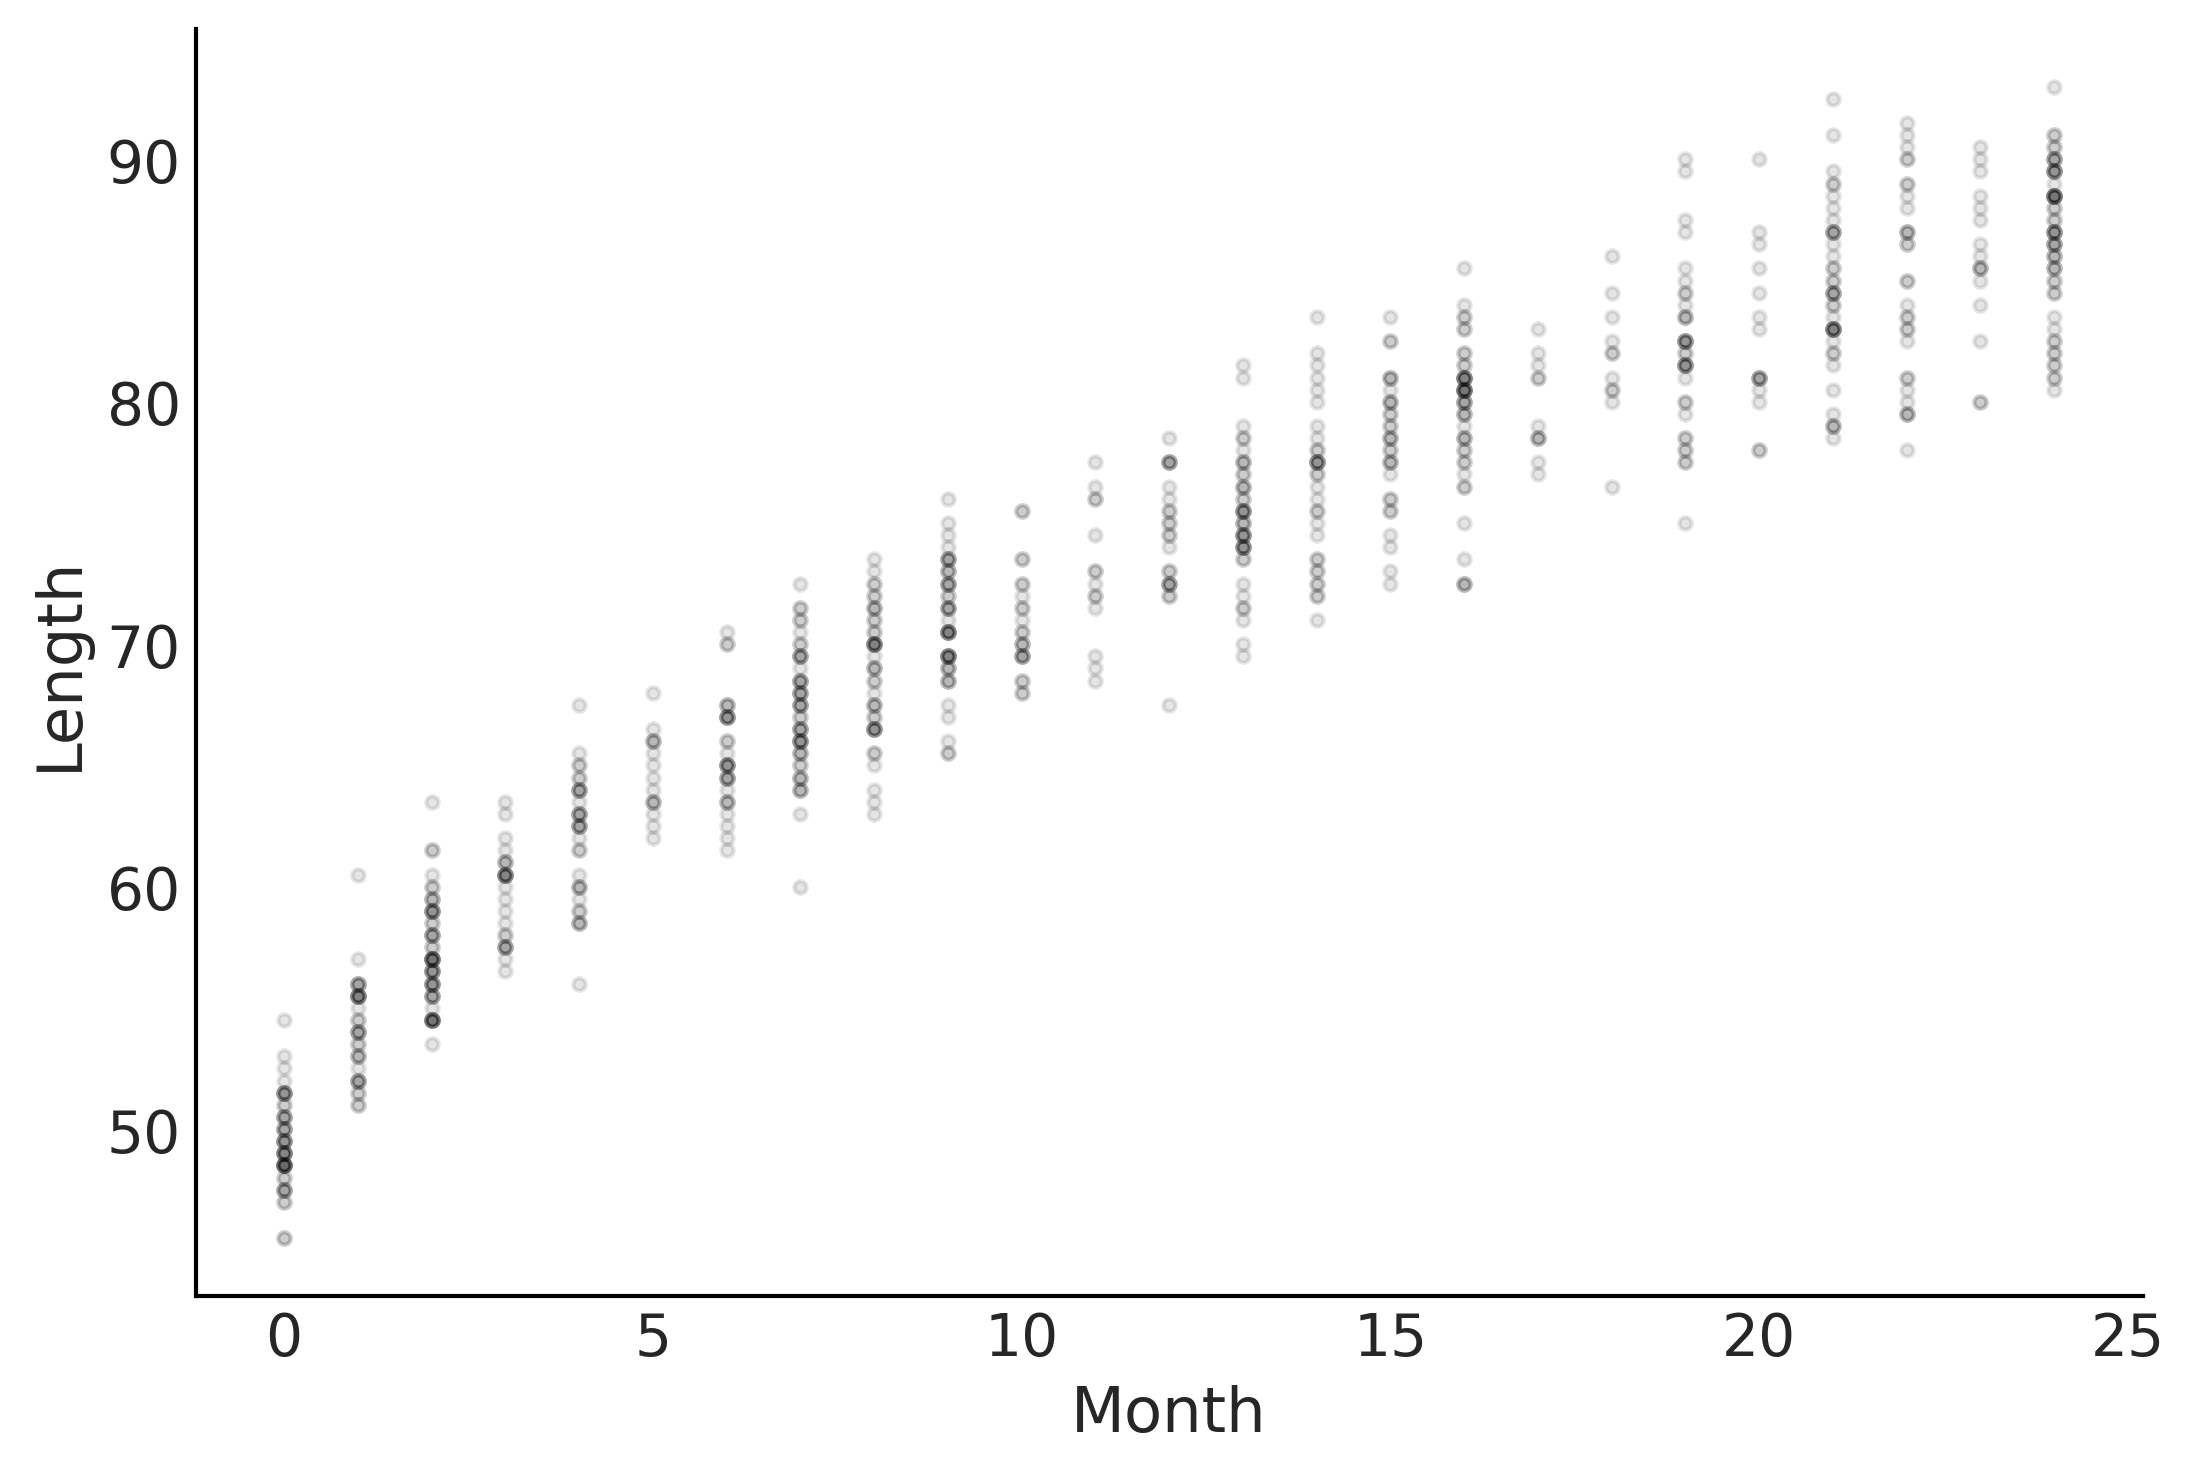

In [4]:
babies = pd.read_csv('../data/babies.csv')

# Add a constant term so we can use a the dot product approach
babies["Intercept"] = 1

fig, ax = plt.subplots()

ax.plot(babies["Month"], babies["Length"], 'C0.', alpha=0.1)
ax.set_ylabel("Length")
ax.set_xlabel("Month");

用普通线性模型拟合年龄与长度的关系：

In [29]:
with pm.Model() as model_baby_linear:
    β = pm.Normal("β", sigma=10, shape=2)

    μ = pm.Deterministic("μ", pm.math.dot(babies[["Intercept", "Month"]], β))
    ϵ = pm.HalfNormal("ϵ", sigma=10)

    length = pm.Normal("length", mu=μ, sigma=ϵ, observed=babies["Length"])

    loglik = pm.Deterministic('log_likelihood', pm.logp(length, babies["Length"]))

    trace_linear = pm.sample(draws=2000, tune=4000)
    pcc_linear = pm.sample_posterior_predictive(trace_linear)
    trace_linear.extend(pcc_linear)
    trace_linear.add_groups({"log_likelihood": {"length":trace_linear.posterior.log_likelihood}})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, ϵ]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 28 seconds.
Sampling: [length]


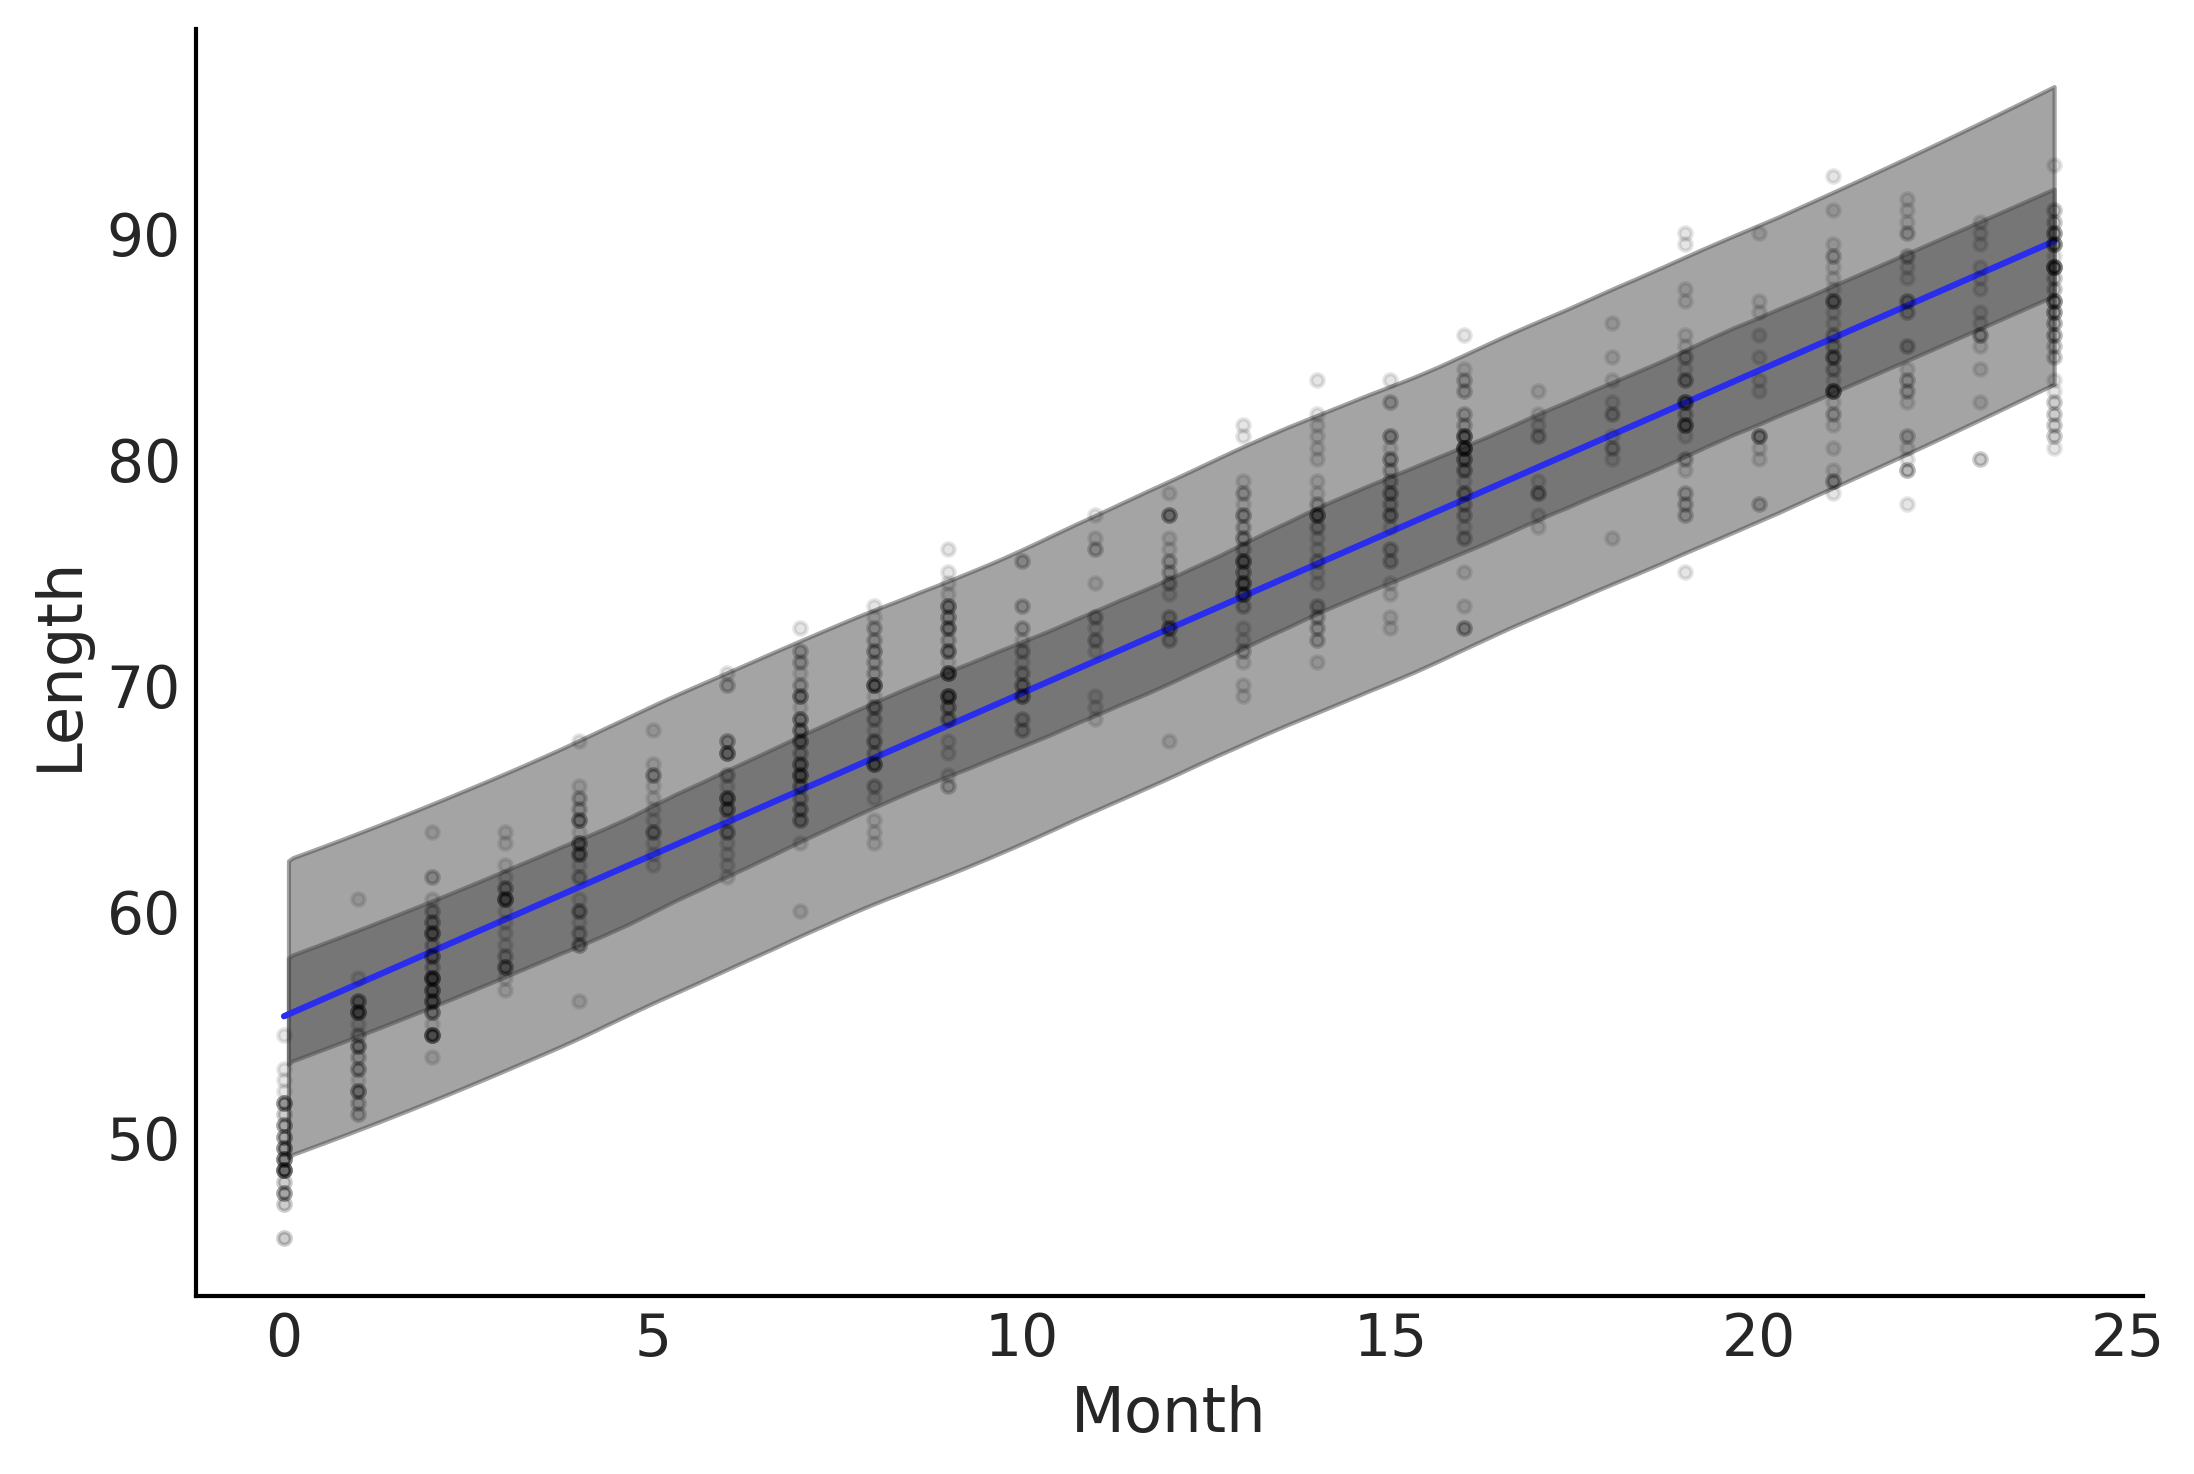

In [31]:
fig, ax = plt.subplots()

ax.set_ylabel("Length")
ax.set_xlabel("Month");

μ_m = trace_linear.posterior["μ"].values.reshape(-1, babies["Length"].shape[0]).mean(axis=0)

ax.plot(babies["Month"], μ_m, c='C4')
az.plot_hdi(babies["Month"], trace_linear.posterior_predictive["length"], hdi_prob=.50, ax=ax)
az.plot_hdi(babies["Month"], trace_linear.posterior_predictive["length"], hdi_prob=.94, ax=ax)

ax.plot(babies["Month"], babies["Length"], 'C0.', alpha=0.1)

以上模型假设年龄与长度的关系是线性的，但是我们可以看到，年龄与长度的关系是非线性的。我们可以对年龄进行平方根变化，然后再拟合模型：

In [36]:
with pm.Model() as model_baby_sqrt:
    β = pm.Normal("β", sigma=10, shape=2)

    μ = pm.Deterministic("μ", β[0] + β[1] * np.sqrt(babies["Month"]))
    σ = pm.HalfNormal("σ", sigma=10)

    length = pm.Normal("length", mu=μ, sigma=σ, observed=babies["Length"])
    loglik = pm.Deterministic('log_likelihood', pm.logp(length, babies["Length"]))
    inf_data_sqrt = pm.sample(draws=2000, tune=4000)
    ppc_baby_sqrt = pm.sample_posterior_predictive(inf_data_sqrt)
    inf_data_sqrt.extend(ppc_baby_sqrt)
    inf_data_sqrt.add_groups({"log_likelihood": {"length":inf_data_sqrt.posterior.log_likelihood}})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, σ]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 29 seconds.
Sampling: [length]


<Axes: xlabel='Square Root of Month'>

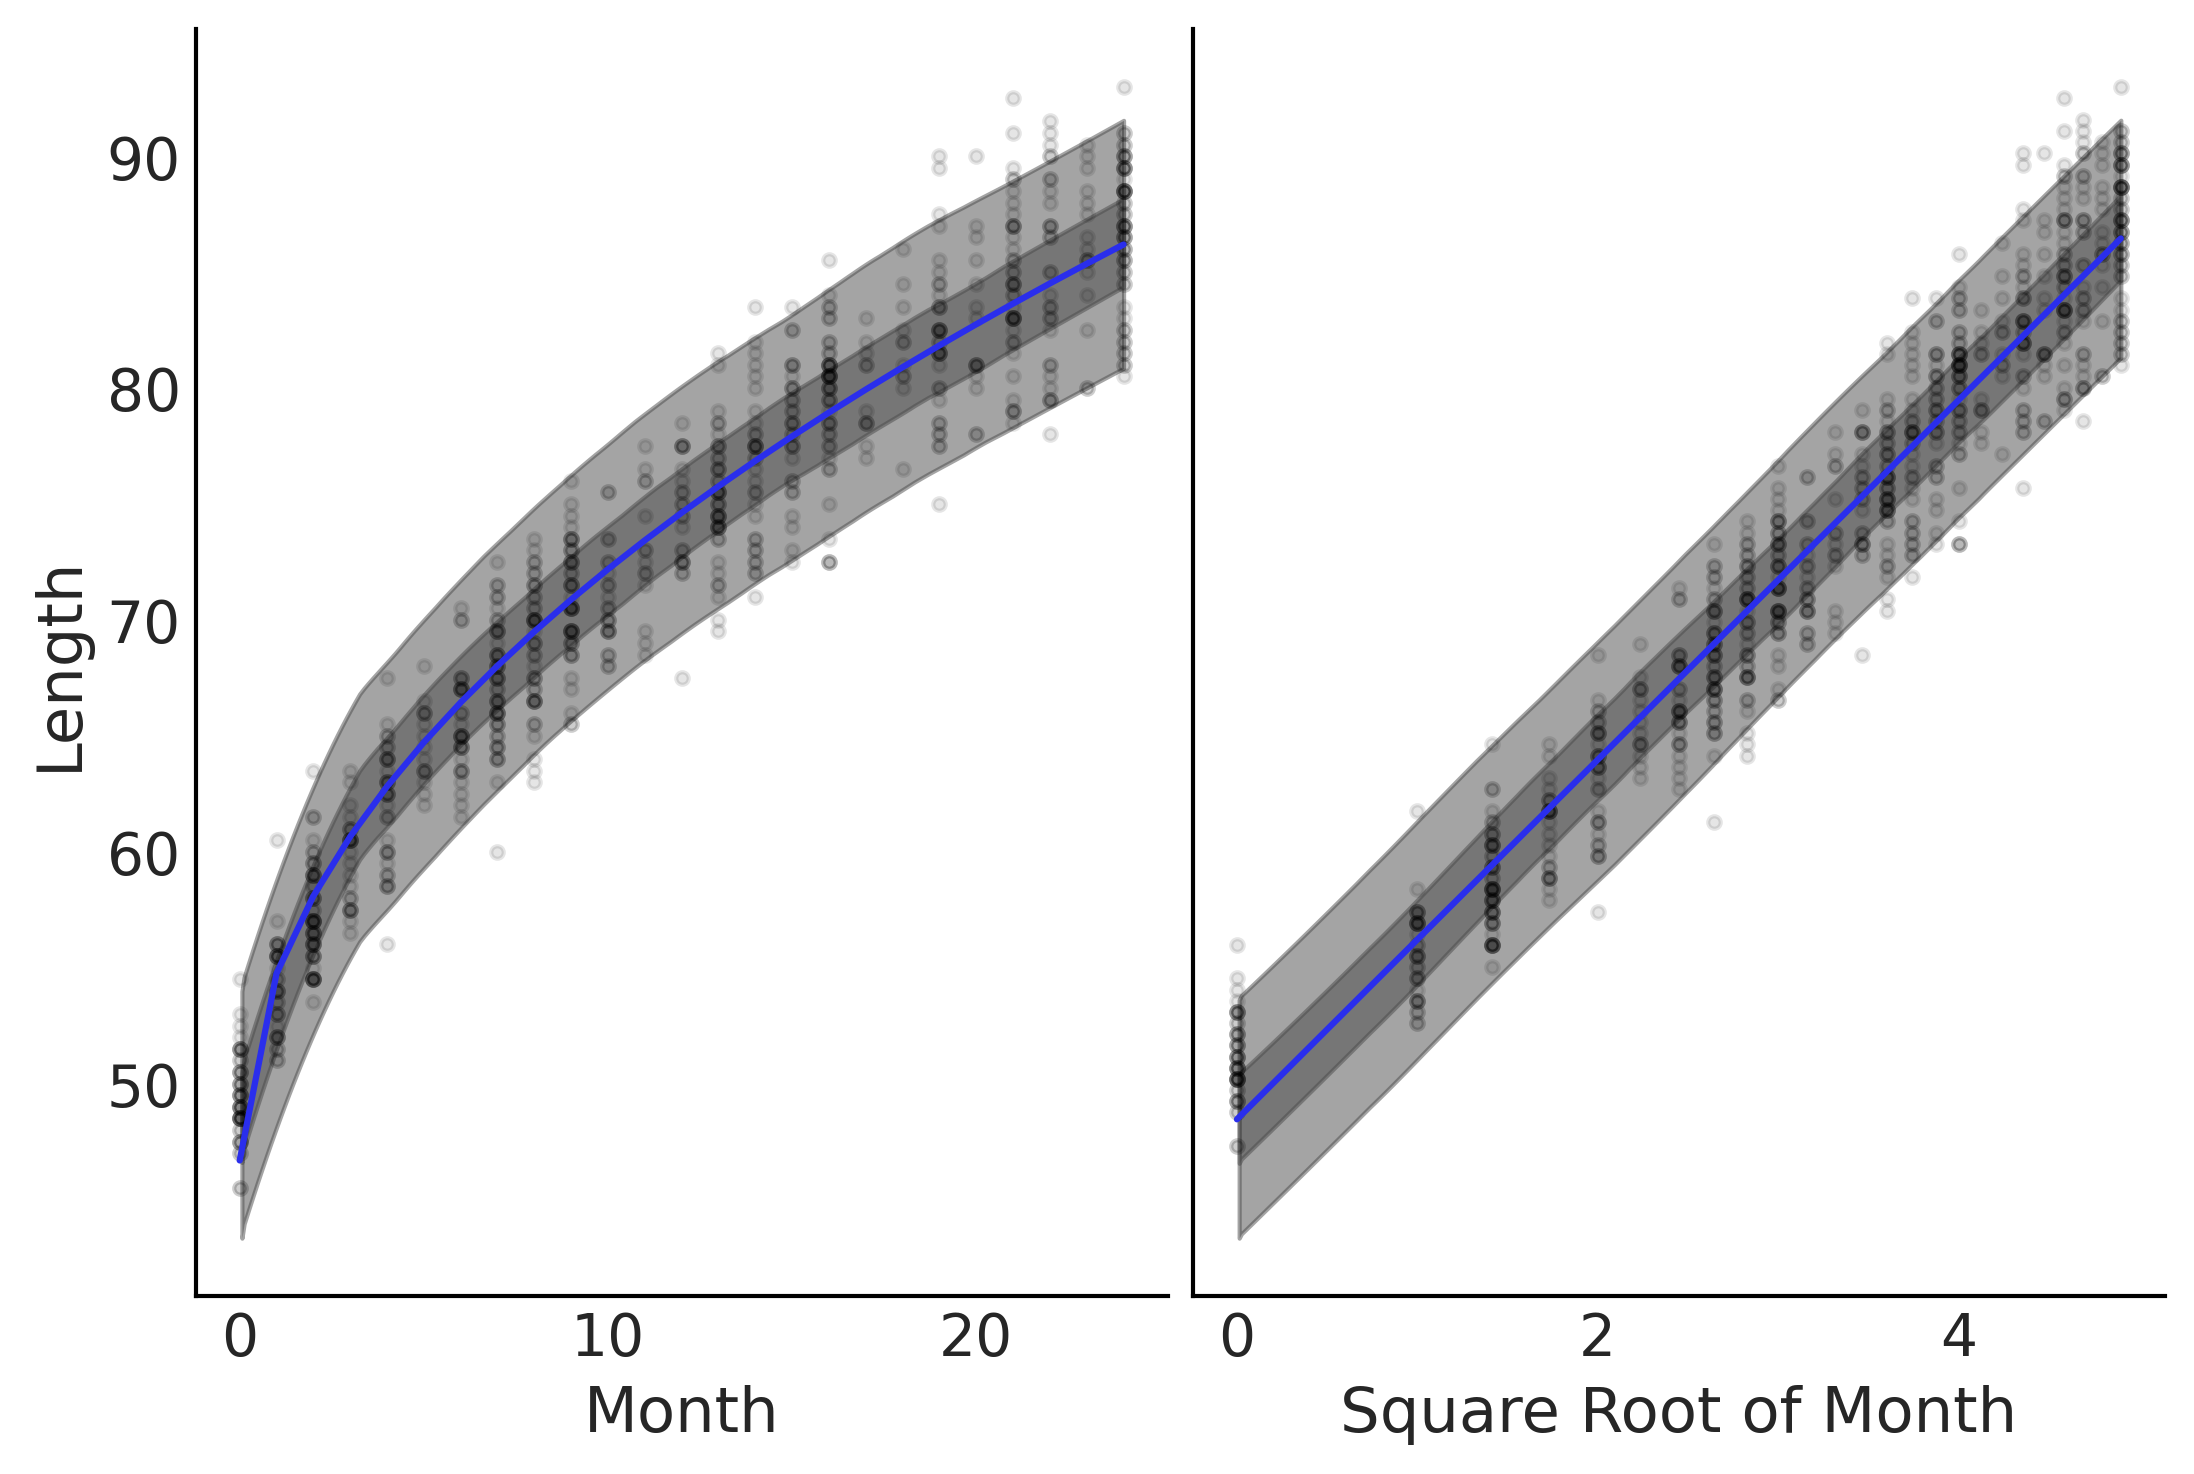

In [24]:
fig, axes = plt.subplots(1,2)
axes[0].plot(babies["Month"], babies["Length"], 'C0.', alpha=0.1)

μ_m = inf_data_sqrt.posterior["μ"].values.reshape(-1, babies["Length"].shape[0]).mean(axis=0)

axes[0].plot(babies["Month"], μ_m, c='C4')
az.plot_hdi(babies["Month"], inf_data_sqrt.posterior_predictive["length"], hdi_prob=.50, ax=axes[0])
az.plot_hdi(babies["Month"], inf_data_sqrt.posterior_predictive["length"], hdi_prob=.94, ax=axes[0])

axes[0].set_ylabel("Length")
axes[0].set_xlabel("Month");

axes[1].plot(np.sqrt(babies["Month"]), babies["Length"], 'C0.', alpha=0.1)
axes[1].set_xlabel("Square Root of Month");

az.plot_hdi(np.sqrt(babies["Month"]), inf_data_sqrt.posterior_predictive["length"], hdi_prob=.50, ax=axes[1])
az.plot_hdi(np.sqrt(babies["Month"]), inf_data_sqrt.posterior_predictive["length"], hdi_prob=.94, ax=axes[1])
axes[1].plot(np.sqrt(babies["Month"]), μ_m, c='C4')

axes[1].set_yticks([])
axes[1]

In [61]:
az.compare({"Linear Model":trace_linear, "Non Linear Model":inf_data_sqrt})

/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


rank     elpd_loo     p_loo  elpd_diff    weight         se  \
Non Linear Model     0 -1968.150184  3.013602    0.00000  0.929245  18.971148   
Linear Model         1 -2133.262994  3.165222  165.11281  0.070755  18.580309   

                       dse  warning scale  
Non Linear Model   0.00000    False   log  
Linear Model      20.06535    False   log

通过可视化和compare比较，我们可以看到，变换后的模型更好的拟合了数据。

## 4.2. 变方差 Varying Uncertainty

上述模型都假设残差的方差不变。然而固定方差假设可能是有缺陷的建模选择。将不确定性的变化也考虑进来：
$$
\begin{split}
    \mu =& \beta_0 + \beta_1 f_1(X_1) + \dots + \beta_m f_m(X_m) \\
    \sigma =& \delta_0 + \delta_1 g_1(X_1) + \dots + \delta_m g_m(X_m) \\
Y \sim& \mathcal{N}(\mu, \sigma)
\end{split}
$$

第二列对 $\sigma$ 的估计与对均值的估计很想。我们可以用线性模型对模型参数建模。举个例子，我们可以假设 baby 的长度的差异随年龄增加。

In [62]:
with pm.Model() as model_baby_vv:
    β = pm.Normal("β", sigma=10, shape=2)
    
    # Additional variance terms
    δ = pm.HalfNormal("δ", sigma=10, shape=2)

    μ = pm.Deterministic("μ", β[0] + β[1] * np.sqrt(babies["Month"]))
    σ = pm.Deterministic("σ", δ[0] + δ[1] * babies["Month"])

    length = pm.Normal("length", mu=μ, sigma=σ, observed=babies["Length"])
    
    trace_baby_vv = pm.sample(2000, target_accept=.95)
    ppc_baby_vv = pm.sample_posterior_predictive(trace_baby_vv,
                                                 var_names=["length", "σ"])
    trace_baby_vv.extend(ppc_baby_vv)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, δ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.
Sampling: [length]


为了模拟随着观察到的儿童年龄的增长，长度的离散性不断增加，我们改变了我们的定义 $\sigma$ 从固定值到随年龄变化的值。换句话说，我们将模型假设从同方差 **homoscedastic** 更改为异方差 **heteroscedastic**

In [67]:
az.summary(trace_baby_vv, var_names=["δ"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
δ[0]  2.388  0.116   2.177    2.609      0.002    0.002    2730.0    2962.0   
δ[1]  0.038  0.009   0.022    0.057      0.000    0.000    2707.0    2633.0   

      r_hat  
δ[0]    1.0  
δ[1]    1.0

(0.0, 24.0)

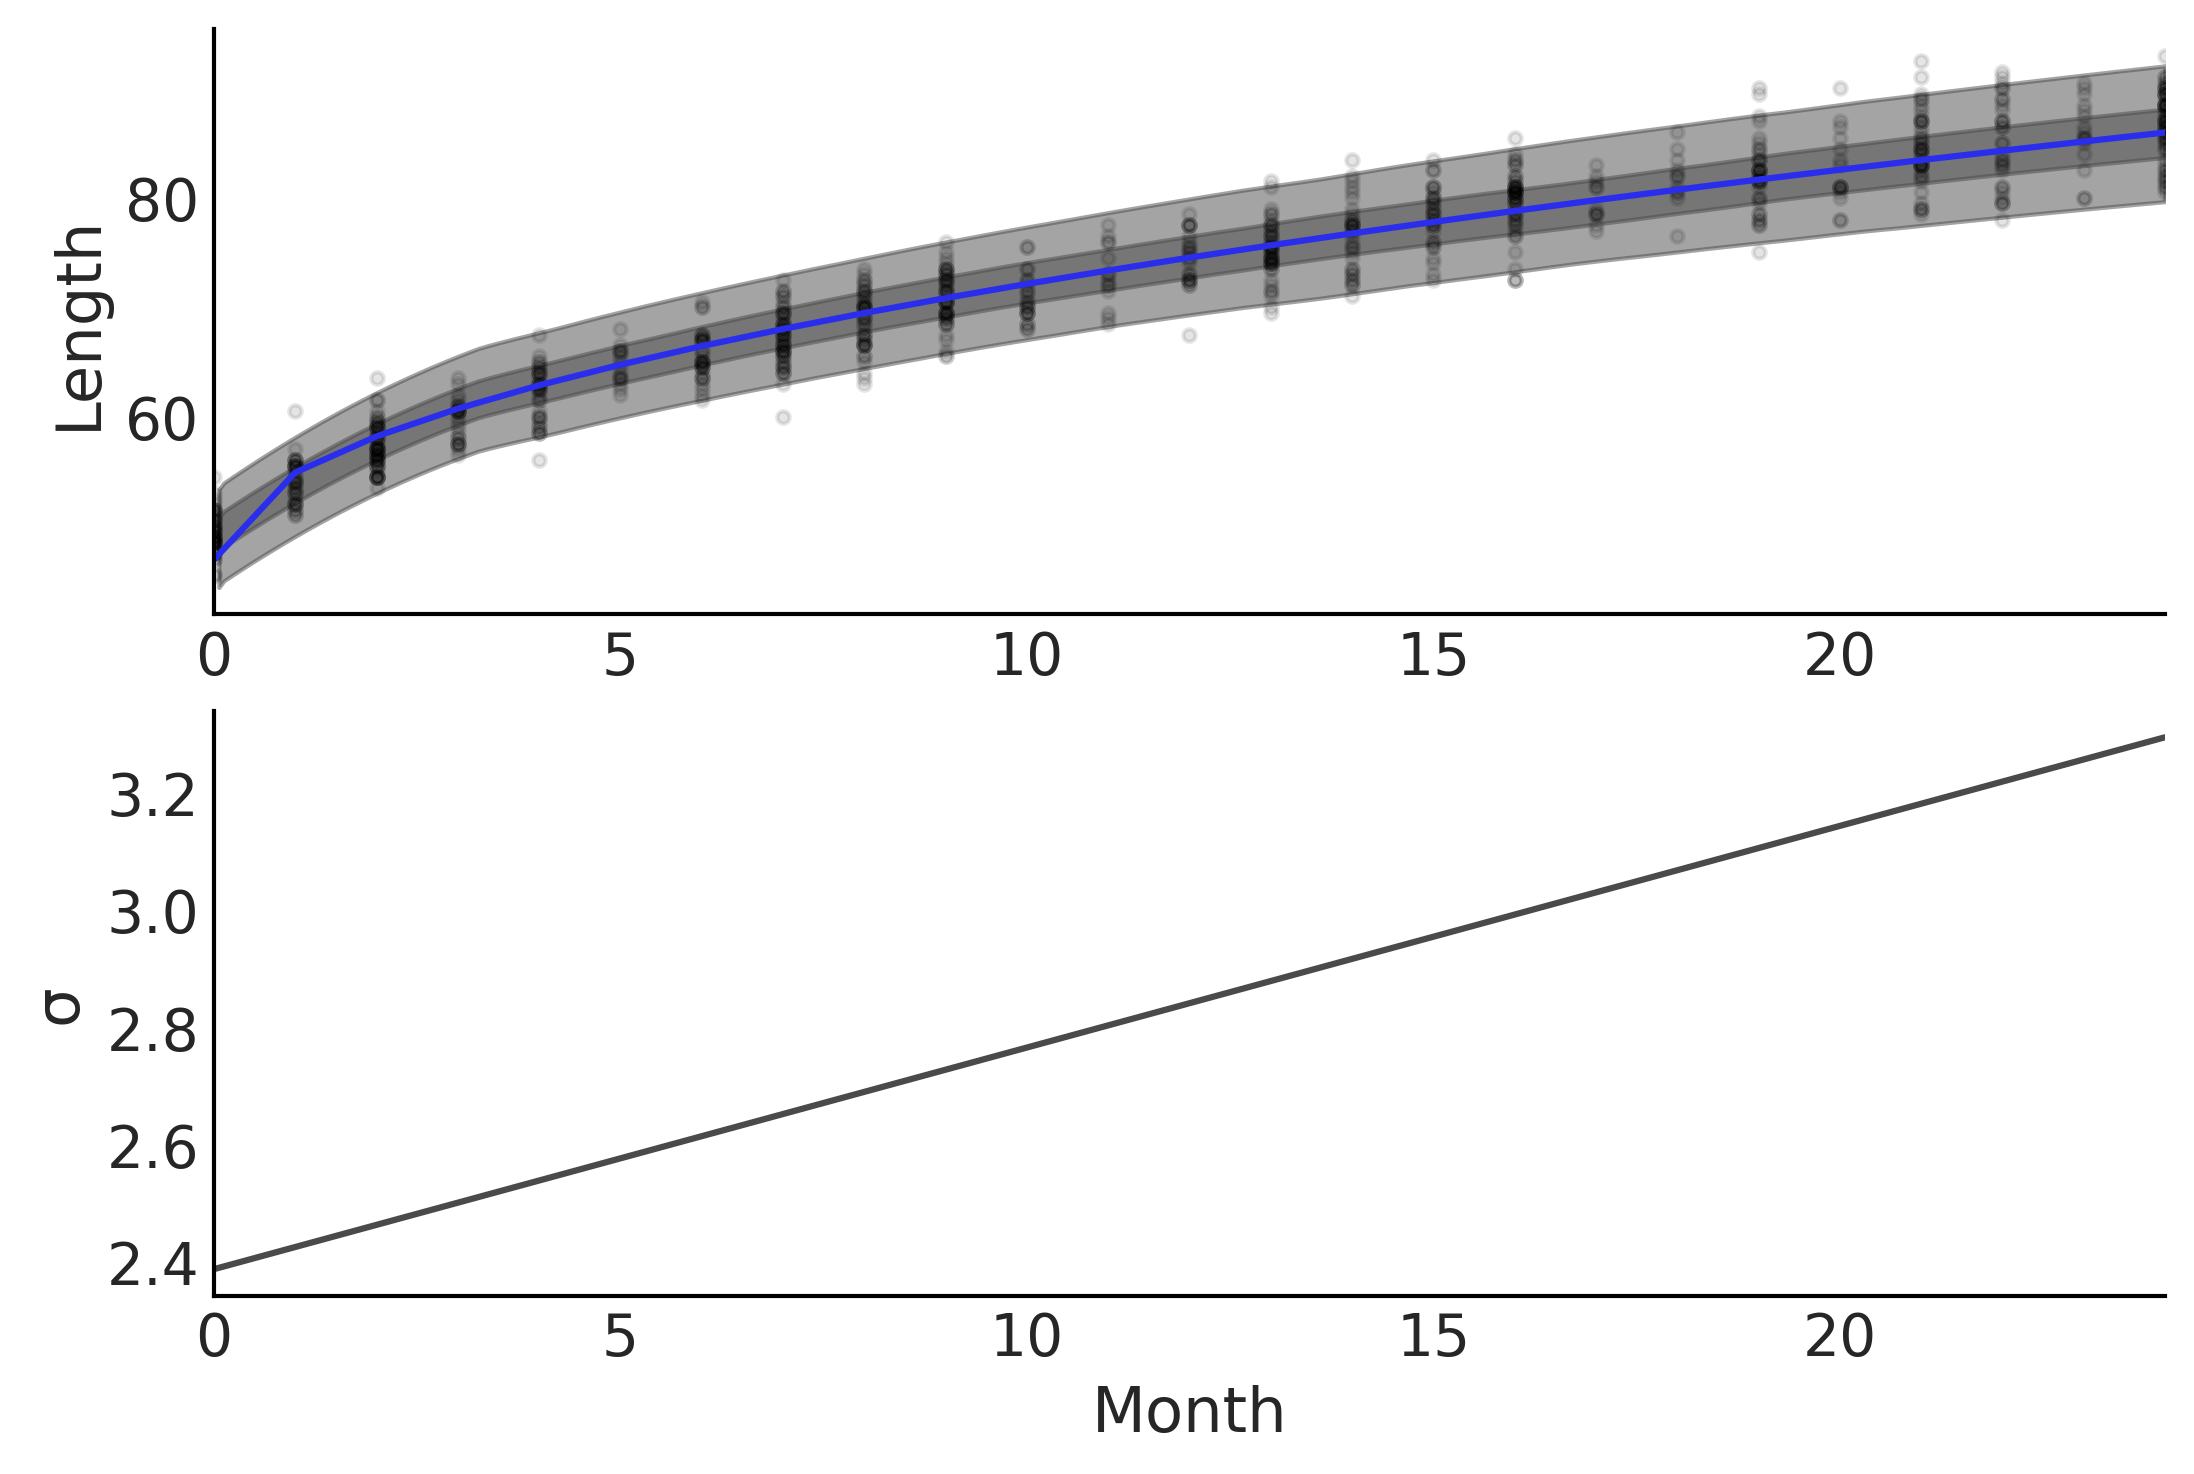

In [70]:
fig, axes = plt.subplots(2,1)

axes[0].plot(babies["Month"], babies["Length"], 'C0.', alpha=0.1)

μ_m = trace_baby_vv.posterior["μ"].values.reshape(-1, babies["Length"].shape[0]).mean(axis=0)

axes[0].plot(babies["Month"], μ_m, c='C4')

az.plot_hdi(babies["Month"], trace_baby_vv.posterior_predictive["length"], hdi_prob=.50, ax=axes[0])
az.plot_hdi(babies["Month"], trace_baby_vv.posterior_predictive["length"], hdi_prob=.94, ax=axes[0])
axes[0].set_ylabel("Length")

σ_m = trace_baby_vv.posterior["σ"].values.reshape(-1, 800).mean(axis=0)

axes[1].plot(babies["Month"], σ_m, c='C1')

axes[1].set_ylabel("σ")
axes[1].set_xlabel("Month")

axes[0].set_xlim(0,24)
axes[1].set_xlim(0,24)

## 4.3. 交互作用

迄今为止在我们的所有模型中，我们假设一个协变量对响应变量的影响独立于任何其他协变量。这并非总是如此。考虑这样一种情况：我们想要为特定城镇的冰淇淋销售建模，只有当天气炎热并且有很多地方可以买到冰淇淋时，我们预计销量才会增加。对这种联合现象进行建模需要我们引入一种交互效应，其中一个协变量对输出变量的影响取决于其他协变量的值。我们可以将交互作用表示为：
$$
\begin{split}
    \mu =& \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1X_2\\
    Y \sim& \mathcal{N}(\mu, \sigma)
\end{split}
$$

让我们使用餐者留下的小费金额建模，我们将重点关注吸烟者与不吸烟者小费金额的差异。特别是我们将研究吸烟与总账单金额之间是否存在交互作用。    
首先我们先假设没有交互作用来建模：

In [90]:
tips_df = pd.read_csv("../data/tips.csv")
tips = tips_df["tip"]
total_bill_c = (tips_df["total_bill"] - tips_df["total_bill"].mean())  
smoker = pd.Categorical(tips_df["smoker"]).codes
tips_df.head()

total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4

In [88]:
with pm.Model() as model_no_interaction:
    β = pm.Normal("β", mu=0, sigma=1, shape=3)
    σ = pm.HalfNormal("σ", 1)

    μ = (β[0] +
         β[1] * total_bill_c + 
         β[2] * smoker)

    obs = pm.Normal("obs", μ, σ, observed=tips)
    trace_no_interaction = pm.sample(1000, tune=1000)

然后增加交互项建模：

In [72]:
with pm.Model() as model_interaction:
    β = pm.Normal("β", mu=0, sigma=1, shape=4)
    σ = pm.HalfNormal("σ", 1)

    μ = (β[0]
       + β[1] * total_bill_c
       + β[2] * smoker
       + β[3] * smoker * total_bill_c
        )

    obs = pm.Normal("obs", μ, σ, observed=tips)
    trace_interaction = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **h

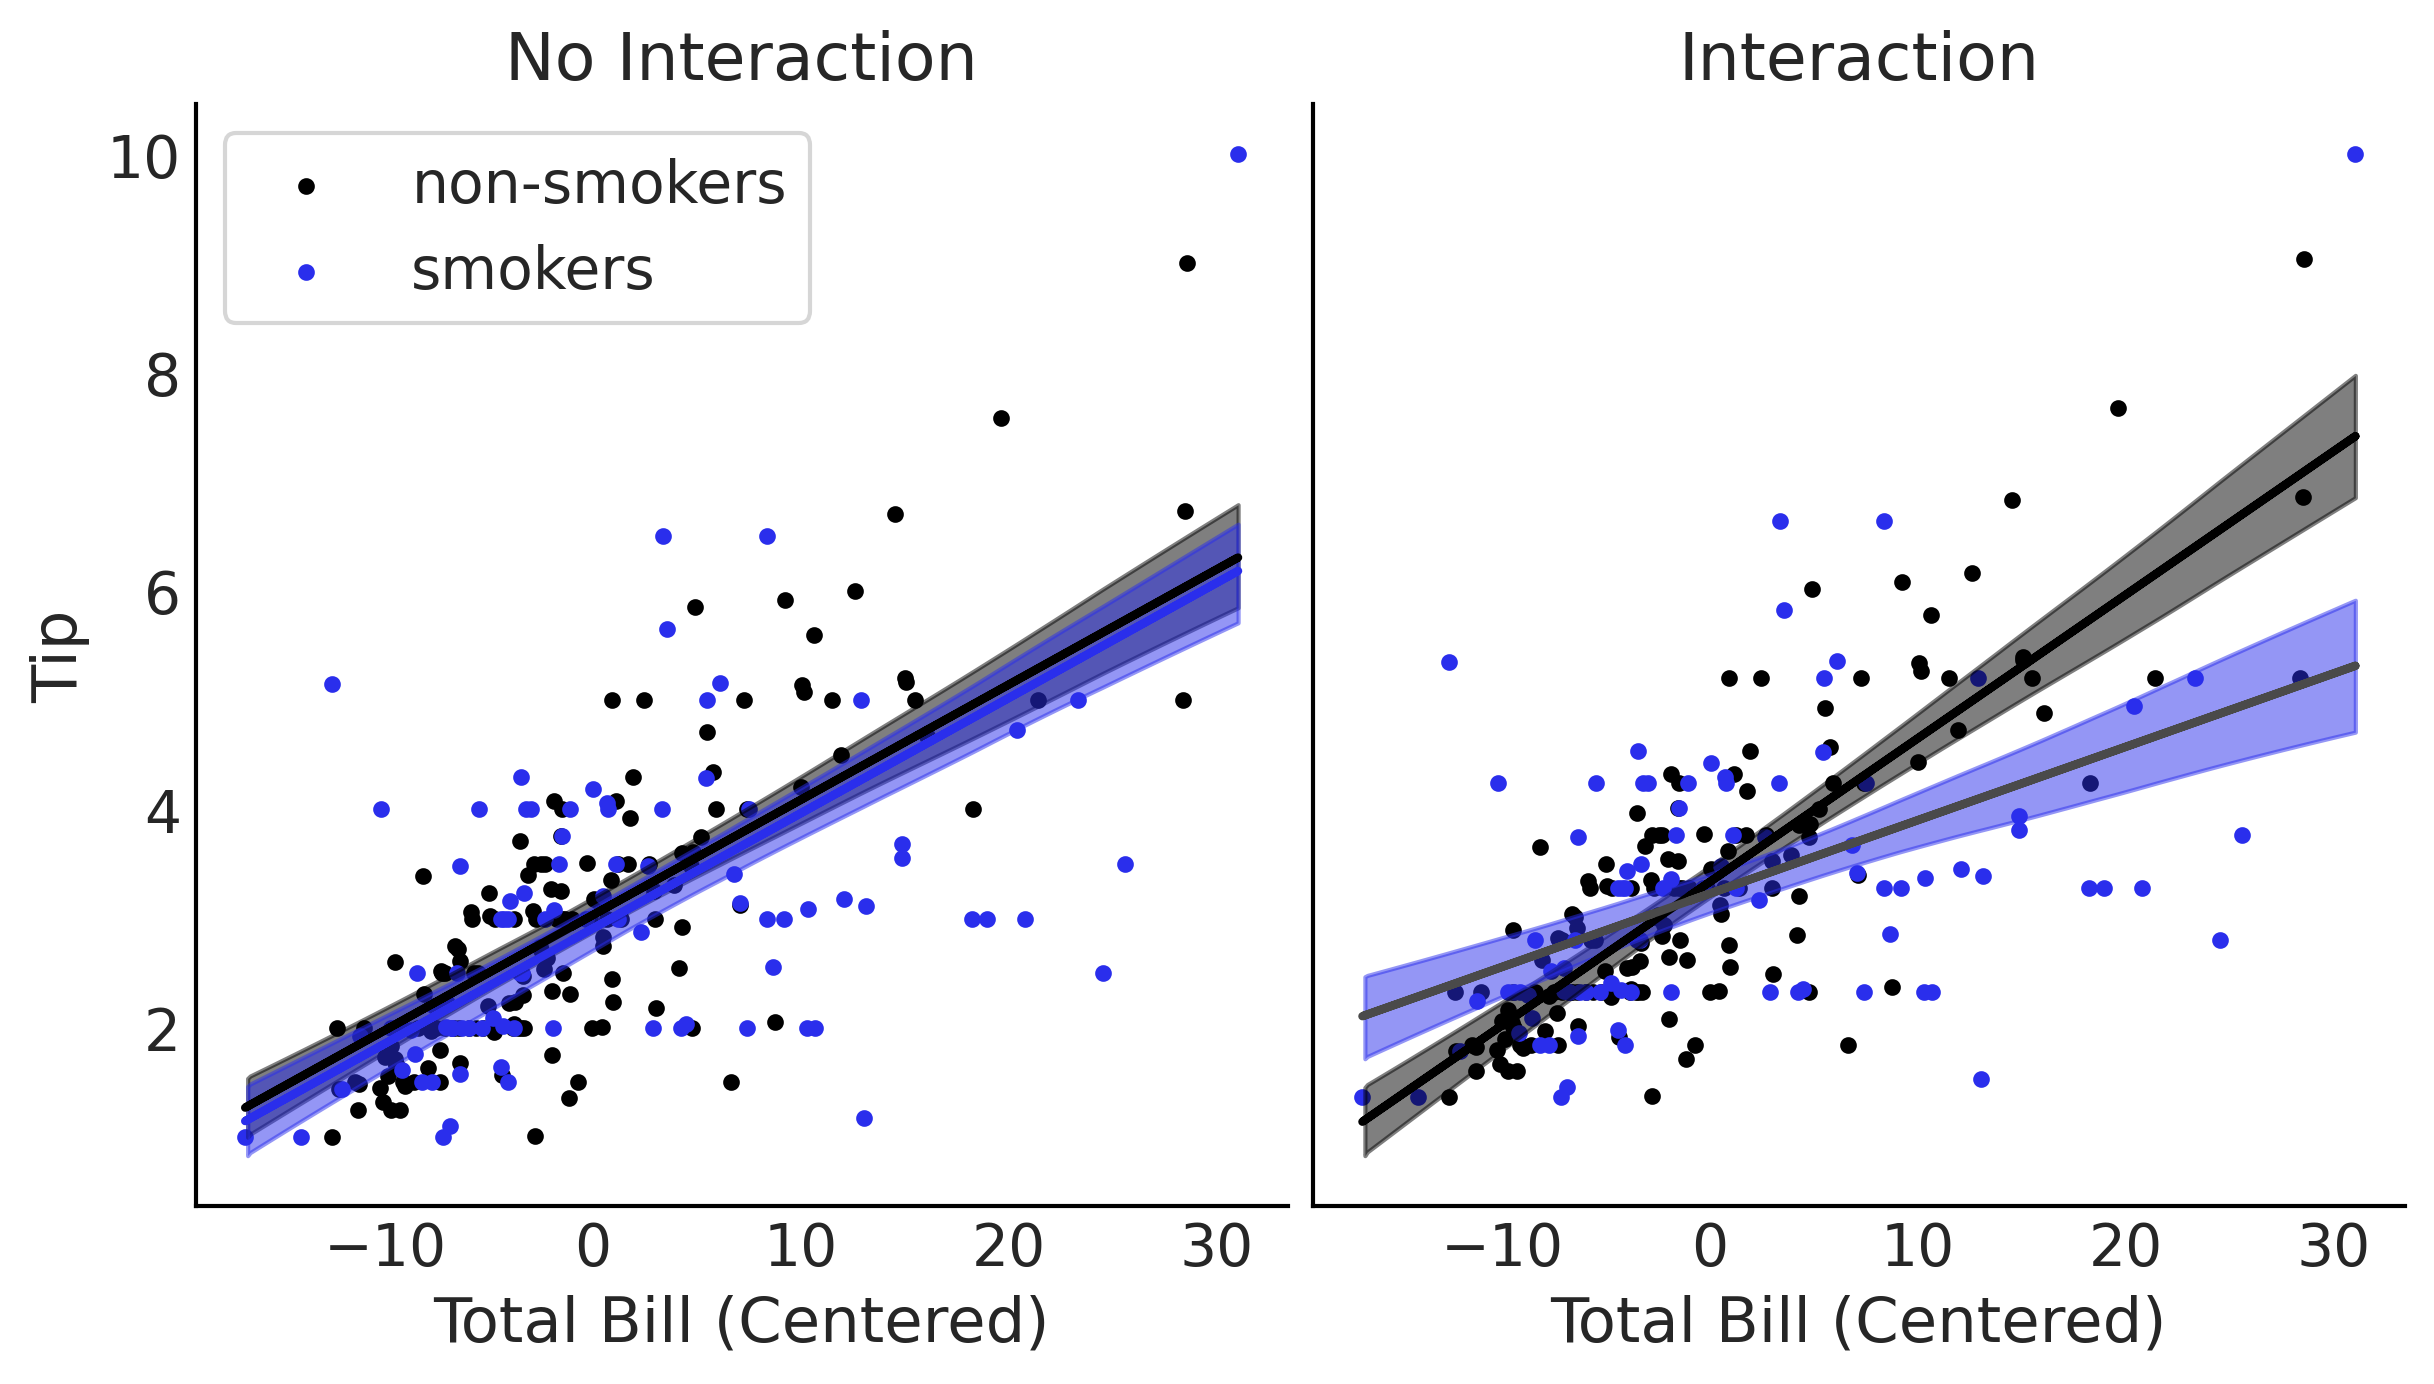

In [115]:
_, ax = plt.subplots(1, 2, figsize=(8, 4.5))

β0_nonint = trace_no_interaction.posterior['β'][:,:,0].values.reshape(-1)
β1_nonint = trace_no_interaction.posterior['β'][:,:,1].values.reshape(-1)
β2_nonint = trace_no_interaction.posterior['β'][:,:,2].values.reshape(-1)

pred_y_non_smokers = β0_nonint + β1_nonint * total_bill_c.values[:,None]
pred_y_smokers = β0_nonint + β1_nonint * total_bill_c.values[:,None] + β2_nonint

ax[0].scatter(total_bill_c[smoker==0], tips[smoker==0], label='non-smokers', marker='.')
ax[0].scatter(total_bill_c[smoker==1], tips[smoker==1], label='smokers', marker='.', c="C4")
ax[0].set_xlabel('Total Bill (Centered)')
ax[0].set_ylabel('Tip')
ax[0].legend(frameon=True)

ax[0].plot(total_bill_c, pred_y_non_smokers.mean(1), lw=2)
ax[0].plot(total_bill_c, pred_y_smokers.mean(1), lw=2, c="C4")
ax[0].set_title('No Interaction')

az.plot_hdi(total_bill_c, pred_y_non_smokers.T, color='C0', ax=ax[0])
az.plot_hdi(total_bill_c, pred_y_smokers.T, ax=ax[0], color="C4");

β0_int = trace_interaction.posterior['β'][:,:,0].values.reshape(-1)
β1_int = trace_interaction.posterior['β'][:,:,1].values.reshape(-1)
β2_int = trace_interaction.posterior['β'][:,:,2].values.reshape(-1)
β3_int = trace_interaction.posterior['β'][:,:,3].values.reshape(-1)

# Because smoker=0 I am ommiting the terms including the smoker covariate
pred_y_non_smokers = (β0_int +
                      β1_int * total_bill_c.values[:, None])

# Because x1=1 I am ommiting x1
pred_y_smokers = (β0_int +
                  β1_int * total_bill_c.values[:, None] +
                  β2_int +
                  β3_int * total_bill_c.values[:, None])

ax[1].scatter(total_bill_c[smoker==0], tips[smoker==0], label='non-smokers', marker='.')
ax[1].scatter(total_bill_c[smoker==1], tips[smoker==1], label='smokers', marker='.', c="C4")
ax[1].set_xlabel('Total Bill (Centered)')
ax[1].set_yticks([])

ax[1].set_title('Interaction')

ax[1].plot(total_bill_c, pred_y_non_smokers.mean(1), lw=2)
ax[1].plot(total_bill_c, pred_y_smokers.mean(1), lw=2)
az.plot_hdi(total_bill_c, pred_y_non_smokers.T, color='C0', ax=ax[1])
az.plot_hdi(total_bill_c, pred_y_smokers.T, ax=ax[1], color="C4");

比较左边的非交互模型和右边的交互模型，平均拟合线不再平行，吸烟者和非吸烟者的斜率不同！    
通过引入交互，我们正在构建一个模型，该模型可以有效地将数据分为两类：吸烟者和非吸烟者。使用交互的好处之一是我们使用所有可用数据来拟合单个模型，从而提高估计参数的准确性。针对相同数据构建一个有交互和无交互的模型，以便更轻松地使用 LOO 比较模型。虽然交互效应模型的主要区别在于对每组不同斜率进行建模的灵活性，但对所有数据进行建模会带来许多额外的好处。

## 4.4. 稳健回归 Robust Regression

离群值，顾名思义是指超出“合理预期”范围的观察结果。异常值是不受欢迎的，因为这些数据点中的一个或几个可能会显着改变模型的参数估计。    
至少有两种方法可以解决异常值。一种是使用一些预定义的标准删除数据，例如 3 个标准差或 1.5 倍四分位数范围。另一种策略是选择一个可以处理异常值并仍然提供有用结果的模型。在回归中后者通常被称为稳健回归模型，特别是要注意这些模型对远离大量数据的观察不太敏感。从技术上讲，稳健回归是一种旨在较少受到底层数据生成过程违反假设的影响的方法。在贝叶斯回归中，一个例子是将可能性从高斯分布更改为学生 t 分布。    
高斯分布是由两个参数定义的，这些参数控制高斯分布的平均值和标准差。学生的 t 分布也有相同参数。然而还有一个附加参数，通常称为自由度 $\nu$ 。该参数控制学生 t 分布尾部的权重。将 3 个学生的 t 分布与正态分布进行比较，主要区别在于尾部的密度比例与分布主体的比例。 $\nu$ 较小时，尾部分布的质量较多，因为 $\nu$ 增加集中在体积上的密度比例也会增加，学生的 t 分布变得越来越接近高斯分布。当用学生 t 分布替换高斯似然值时，它可以提供对异常值的鲁棒性。

[]

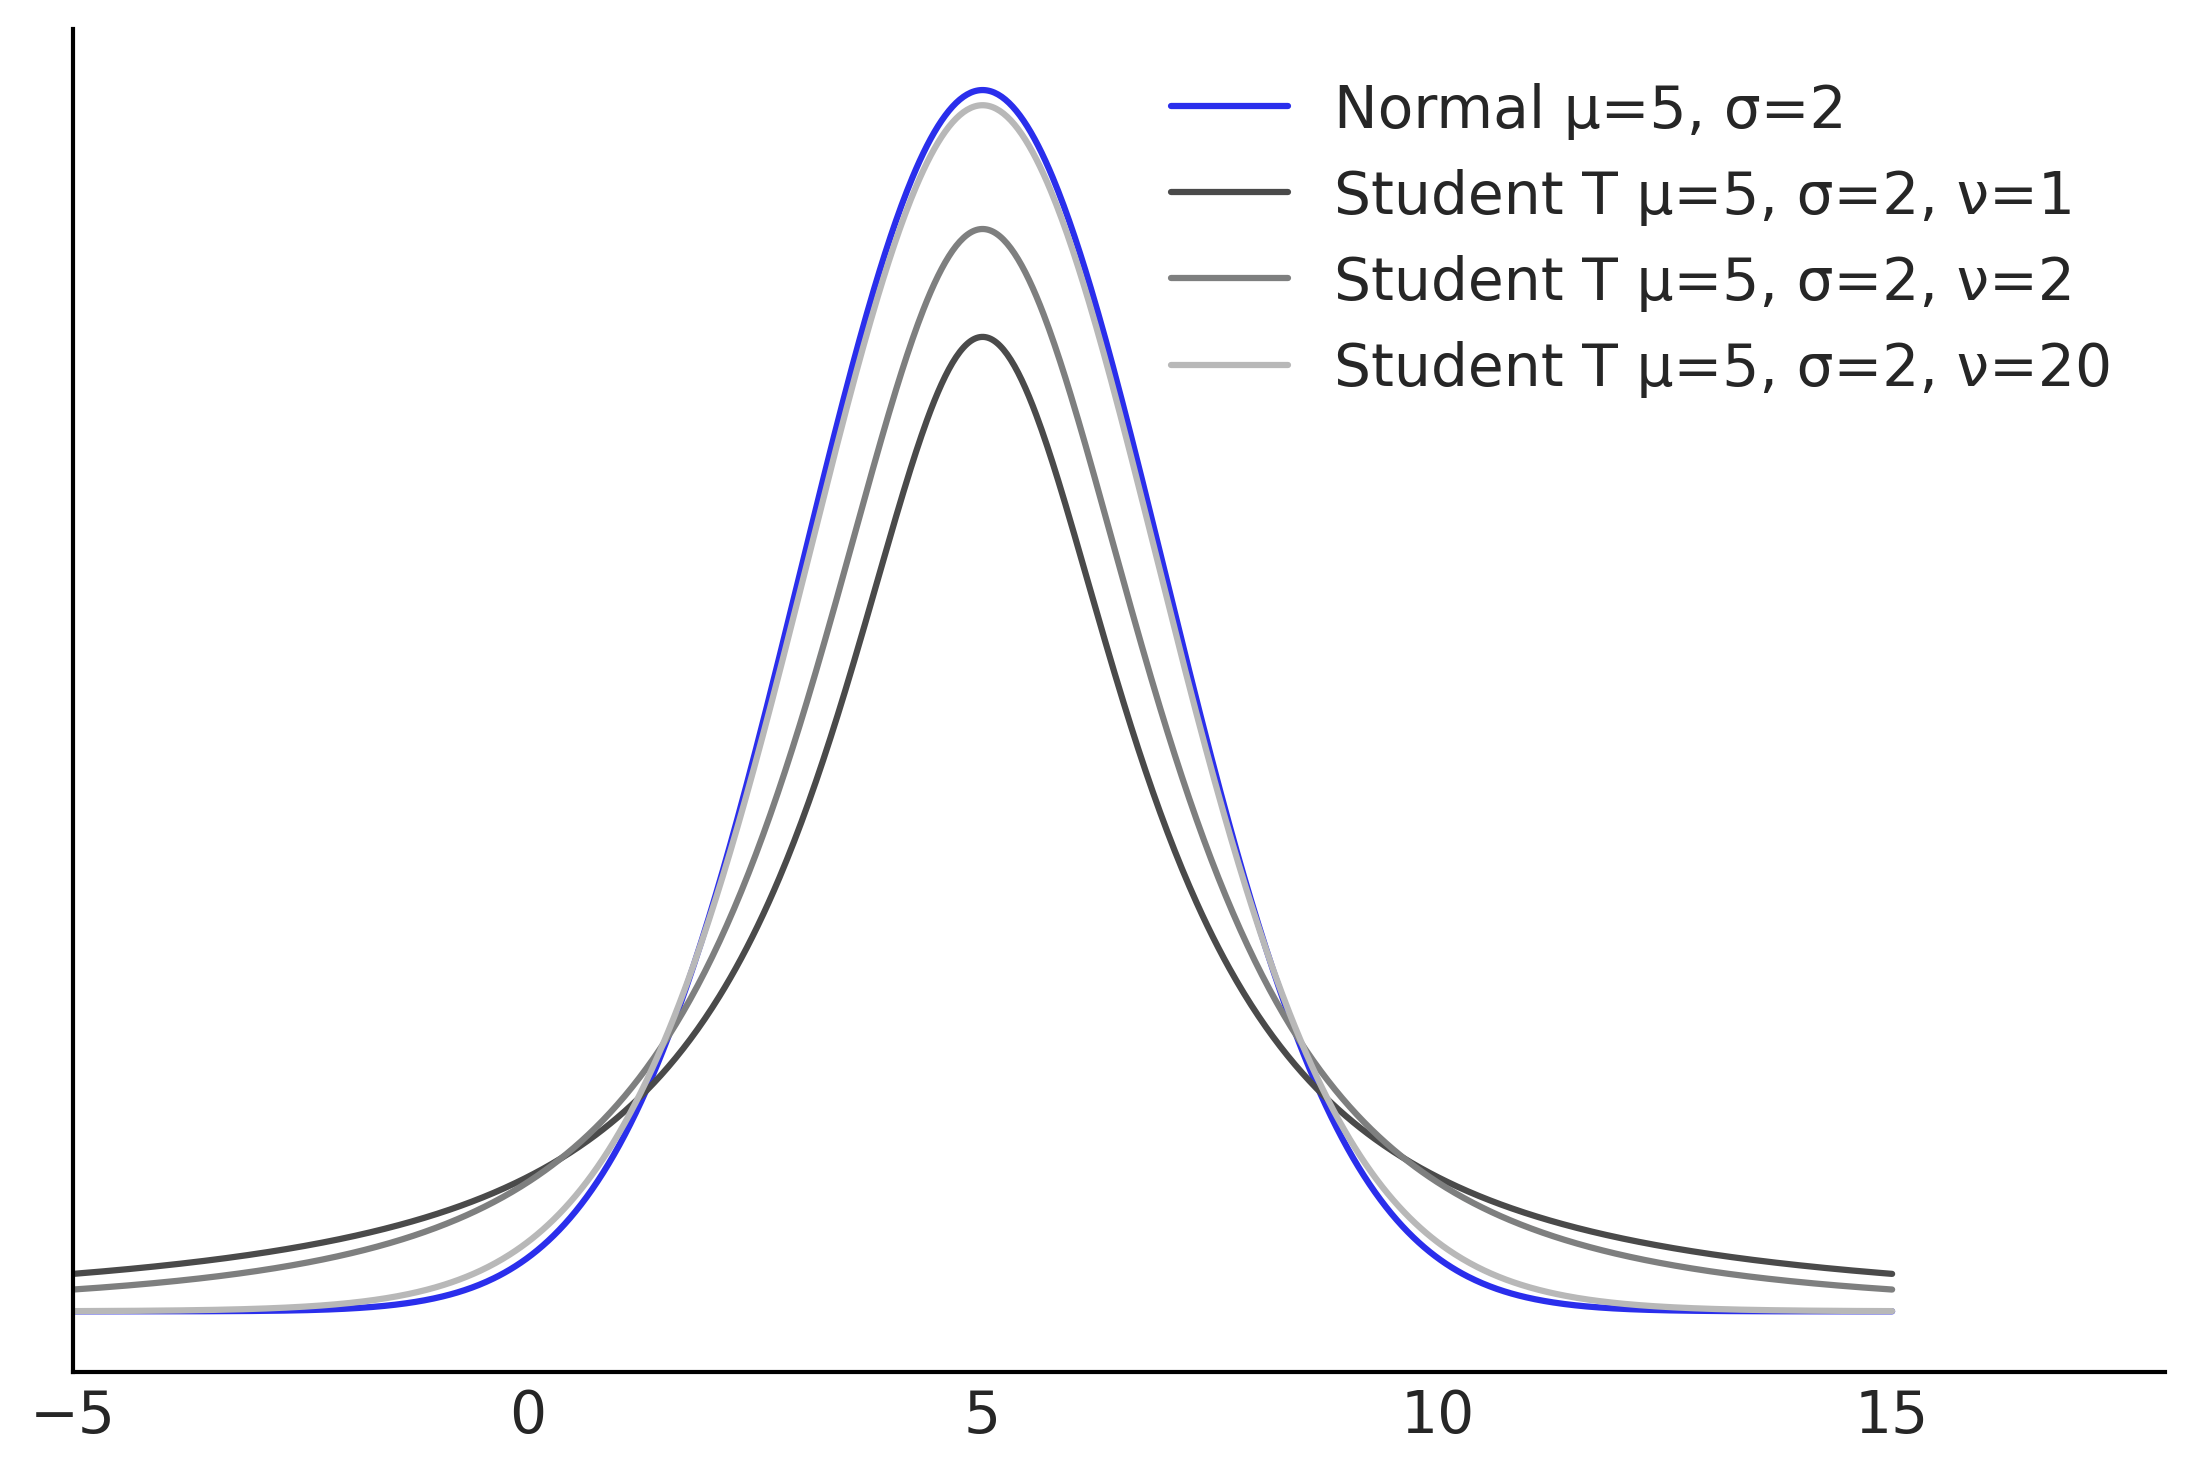

In [122]:
mean = 5
sigma = 2

x = np.linspace(-5, 15, 1000)
fig, ax = plt.subplots()

ax.plot(x, stats.norm(5,2).pdf(x), label=f"Normal μ={mean}, σ={sigma}", color="C4")

for i, nu in enumerate([1, 2, 20],1):
    ax.plot(x, stats.t(loc=5, scale=2, df=nu).pdf(x), label=f"Student T μ={mean}, σ={sigma}, ν={nu}", color=f"C{i}")

ax.set_xlim(-5, 18)
ax.legend(loc="upper right", frameon=False)
ax.set_yticks([])

假设在阿根廷拥有一家餐厅并销售肉馅卷饼。随着时间的推移，您收集了有关您的餐厅每天的顾客数量和阿根廷比索总收入的数据。大多数数据点都沿着一条线分布，但在几天内，每个客户售出的肉馅卷饼数量远高于周围的数据点。这些可能是大型庆祝活动的日子，例如 5 月 25 日或 7 月 9 日，人们会比平常消耗更多的肉馅卷饼。

In [123]:
def generate_sales(*, days, mean, std, label):
    np.random.seed(0)
    df = pd.DataFrame(index=range(1, days+1), columns=["customers", "sales"])
    for day in range(1, days+1):
        num_customers = stats.randint(30, 100).rvs()+1
        
        # This is correct as there is an independent draw for each customers orders
        dollar_sales = stats.norm(mean, std).rvs(num_customers).sum()
        
        df.loc[day, "customers"] = num_customers
        df.loc[day, "sales"] = dollar_sales

    # Fix the types as not to cause Theano errors
    df = df.astype({'customers': 'int32', 'sales': 'float32'})
    
    # Sorting will make plotting the posterior predictive easier later
    df["Food_Category"] = label
    df = df.sort_values("customers")
    return df

Text(0.5, 1.0, 'Empanada Sales')

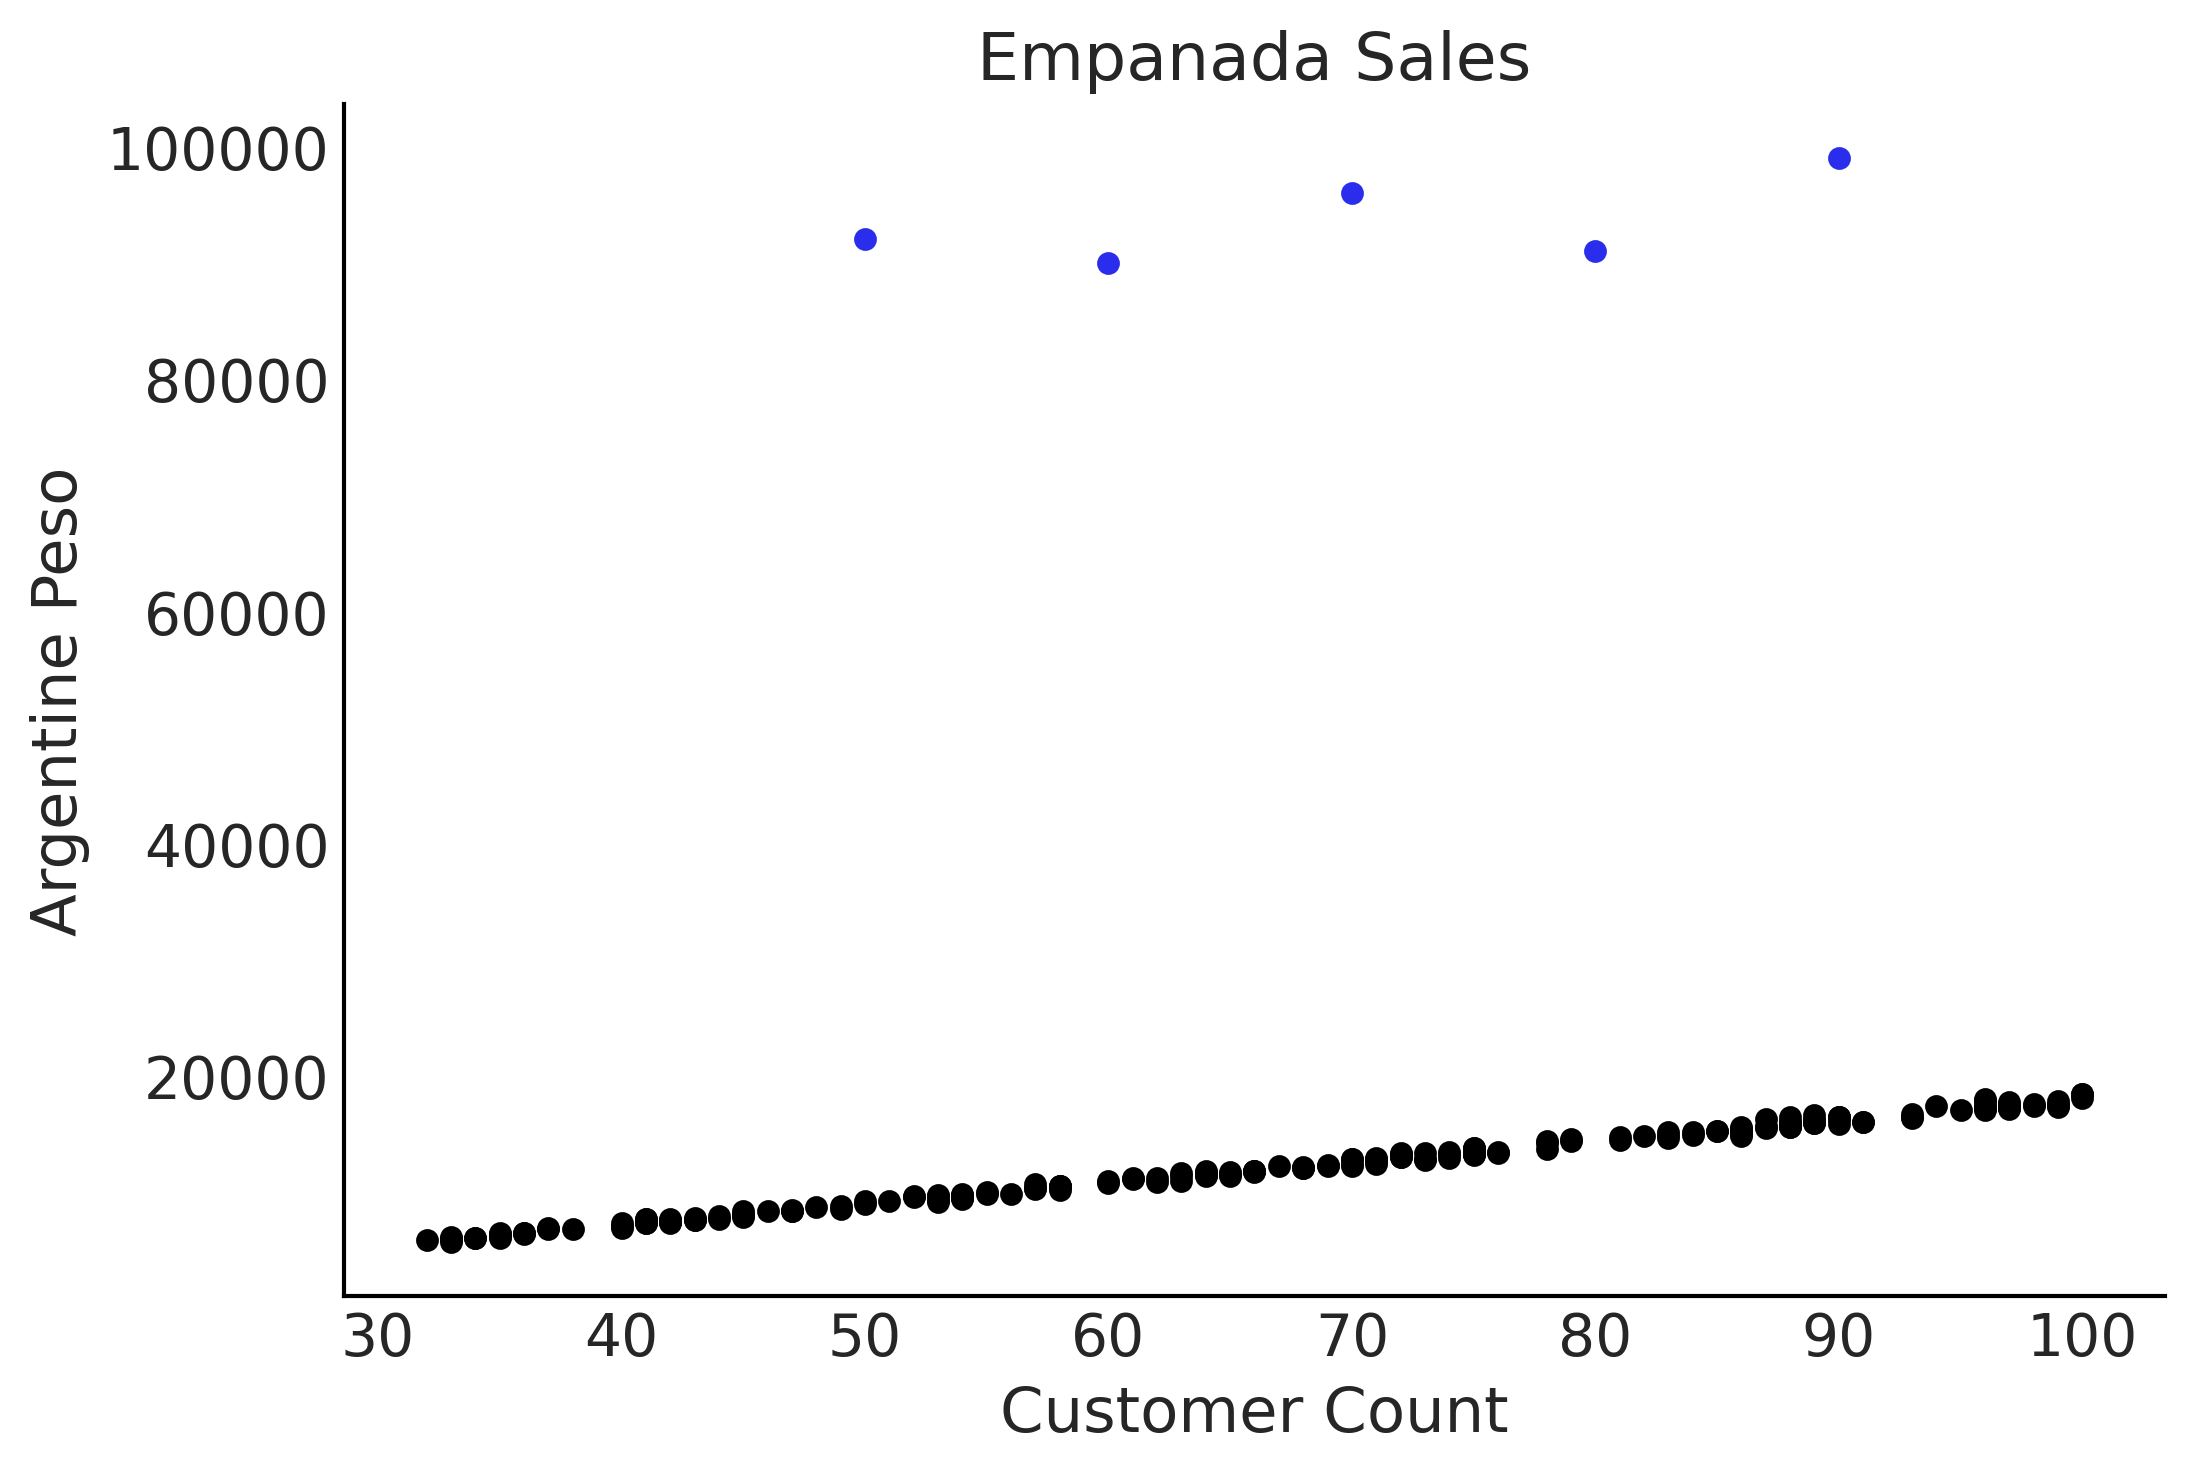

In [126]:
fig, ax = plt.subplots()

empanadas =  generate_sales(days=200, mean=180, std=30, label="Empanada")
empanadas.iloc[0] = [50, 92000, "Empanada"]
empanadas.iloc[1] = [60, 90000, "Empanada"]
empanadas.iloc[2] = [70, 96000, "Empanada"]
empanadas.iloc[3] = [80, 91000, "Empanada"]
empanadas.iloc[4] = [90, 99000, "Empanada"]

empanadas = empanadas.sort_values("customers")

empanadas.sort_values("sales")[:-5].plot(x="customers", y="sales", kind="scatter", ax=ax);
empanadas.sort_values("sales")[-5:].plot(x="customers", y="sales", kind="scatter", c="C4", ax=ax);

ax.set_ylabel("Argentine Peso")
ax.set_xlabel("Customer Count")
ax.set_title("Empanada Sales")

我们都希望估计客户与收入之间的关系。线性回归似乎是合适的，例如使用高斯建模回归。

In [128]:
with pm.Model() as model_non_robust:
    σ = pm.HalfNormal("σ", 50)
    β = pm.Normal("β", mu=150, sigma=20)

    μ = pm.Deterministic("μ", β * empanadas["customers"])

    sales = pm.Normal("sales", mu=μ, sigma=σ, observed=empanadas["sales"])
    
    inf_data_non_robust = pm.sample()
    ppc_empanada_sales = pm.sample_posterior_predictive(
        inf_data_non_robust)
    inf_data_non_robust.extend(ppc_empanada_sales)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
Sampling: [sales]


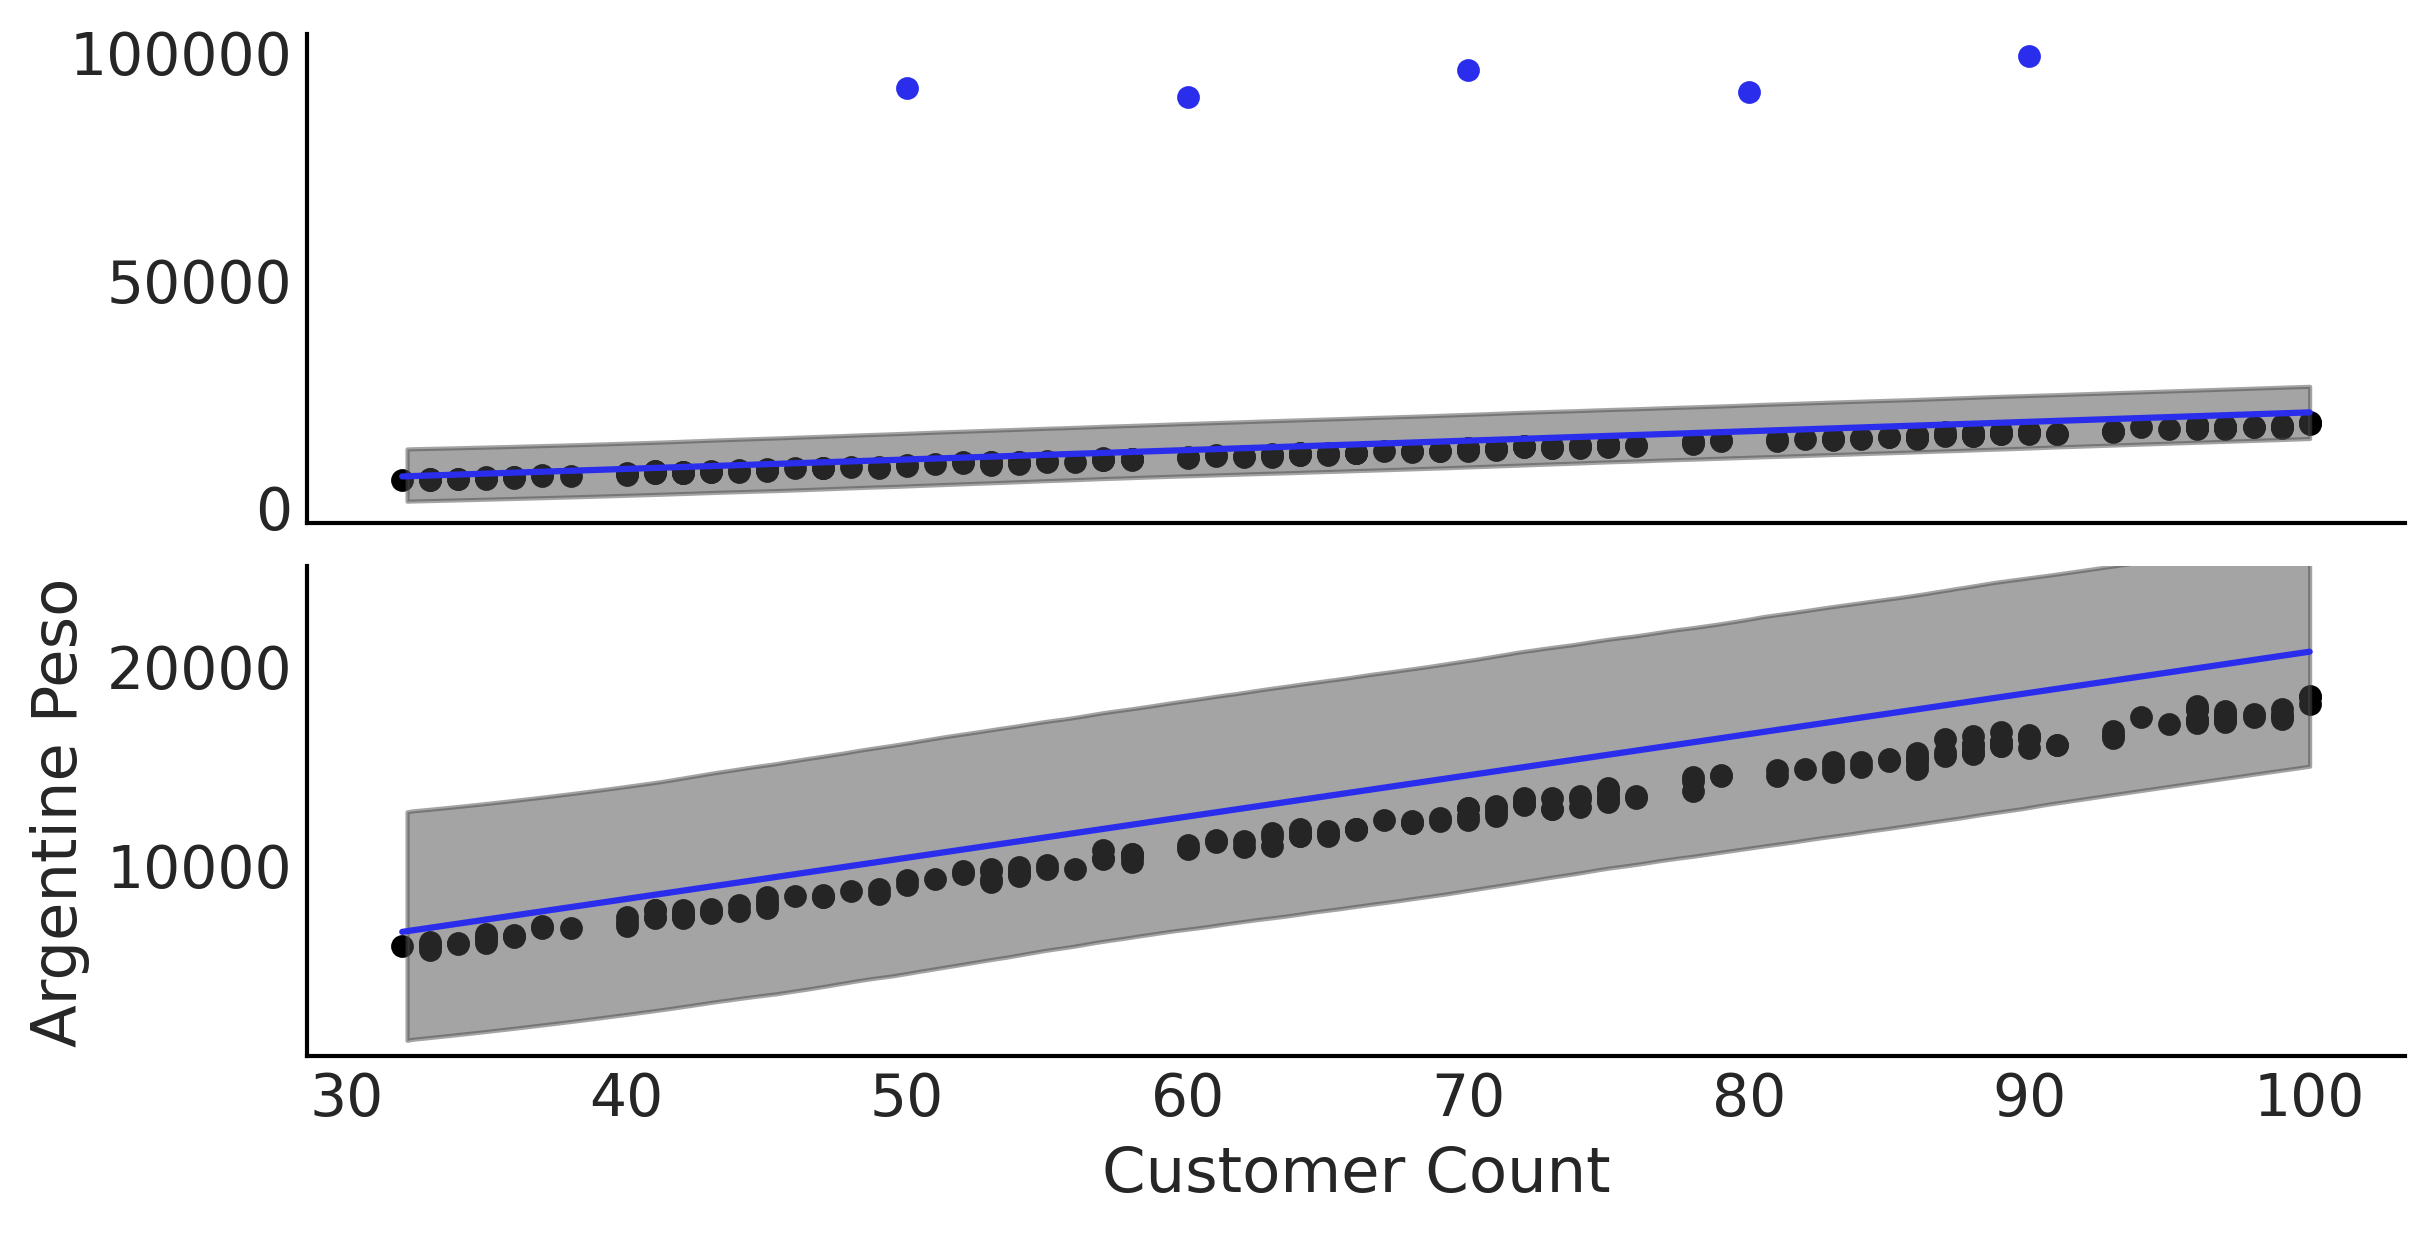

In [129]:
fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
μ_m = inf_data_non_robust.posterior["μ"].values.reshape(-1, empanadas.shape[0]).mean(axis=0)

for i in range(2):
    empanadas.sort_values("sales")[:-5].plot(x="customers", y="sales", kind="scatter", ax=axes[i]);
    empanadas.sort_values("sales")[-5:].plot(x="customers", y="sales", kind="scatter", c="C4", ax=axes[i]);
    axes[i].plot(empanadas.customers, μ_m, c='C4')
    az.plot_hdi(empanadas.customers, inf_data_non_robust.posterior_predictive["sales"], hdi_prob=.95, ax=axes[i])

    axes[1].set_ylabel("Argentine Peso")

axes[0].set_ylabel("")
axes[1].set_xlabel("Customer Count")
axes[1].set_ylim(400, 25000);

In [130]:
az.summary(inf_data_non_robust, kind="stats", var_names=["β", "σ"]).round(1)

mean    sd  hdi_3%  hdi_97%
β   207.0   2.9   201.8    212.5
σ  2950.5  24.3  2904.5   2995.8

在预测完成后，我们可视化结果并且，并且用表格列出参数情况。看起来结果不令人满意。    
    
我们可以重新训练模型，但是这次使用学生 t 分布来建模数据。结果 $\sigma$ 的估计值从2900下降到152

In [131]:
with pm.Model() as model_robust:
    σ = pm.HalfNormal("σ", 50)
    β = pm.Normal("β", mu=150, sigma=20)
    ν = pm.HalfNormal("ν", 20)

    μ = pm.Deterministic("μ", β * empanadas["customers"])
    
    sales = pm.StudentT("sales", mu=μ, sigma=σ, nu=ν,
                        observed=empanadas["sales"])
        
    inf_data_robust = pm.sample(random_seed=0)
    ppc_empanada_sales_robust = pm.sample_posterior_predictive(
                                        inf_data_robust)
    
    inf_data_robust.extend(ppc_empanada_sales_robust)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, ν]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
Sampling: [sales]


In [132]:
az.summary(inf_data_robust, var_names=["β", "σ", "ν"], kind="stats").round(1)

mean    sd  hdi_3%  hdi_97%
β  179.6   0.2   179.1    180.1
σ  152.2  13.8   127.0    178.7
ν    1.3   0.2     1.0      1.6

Text(0.5, 1.0, 'Empanada Sales with Robust Regression Fit')

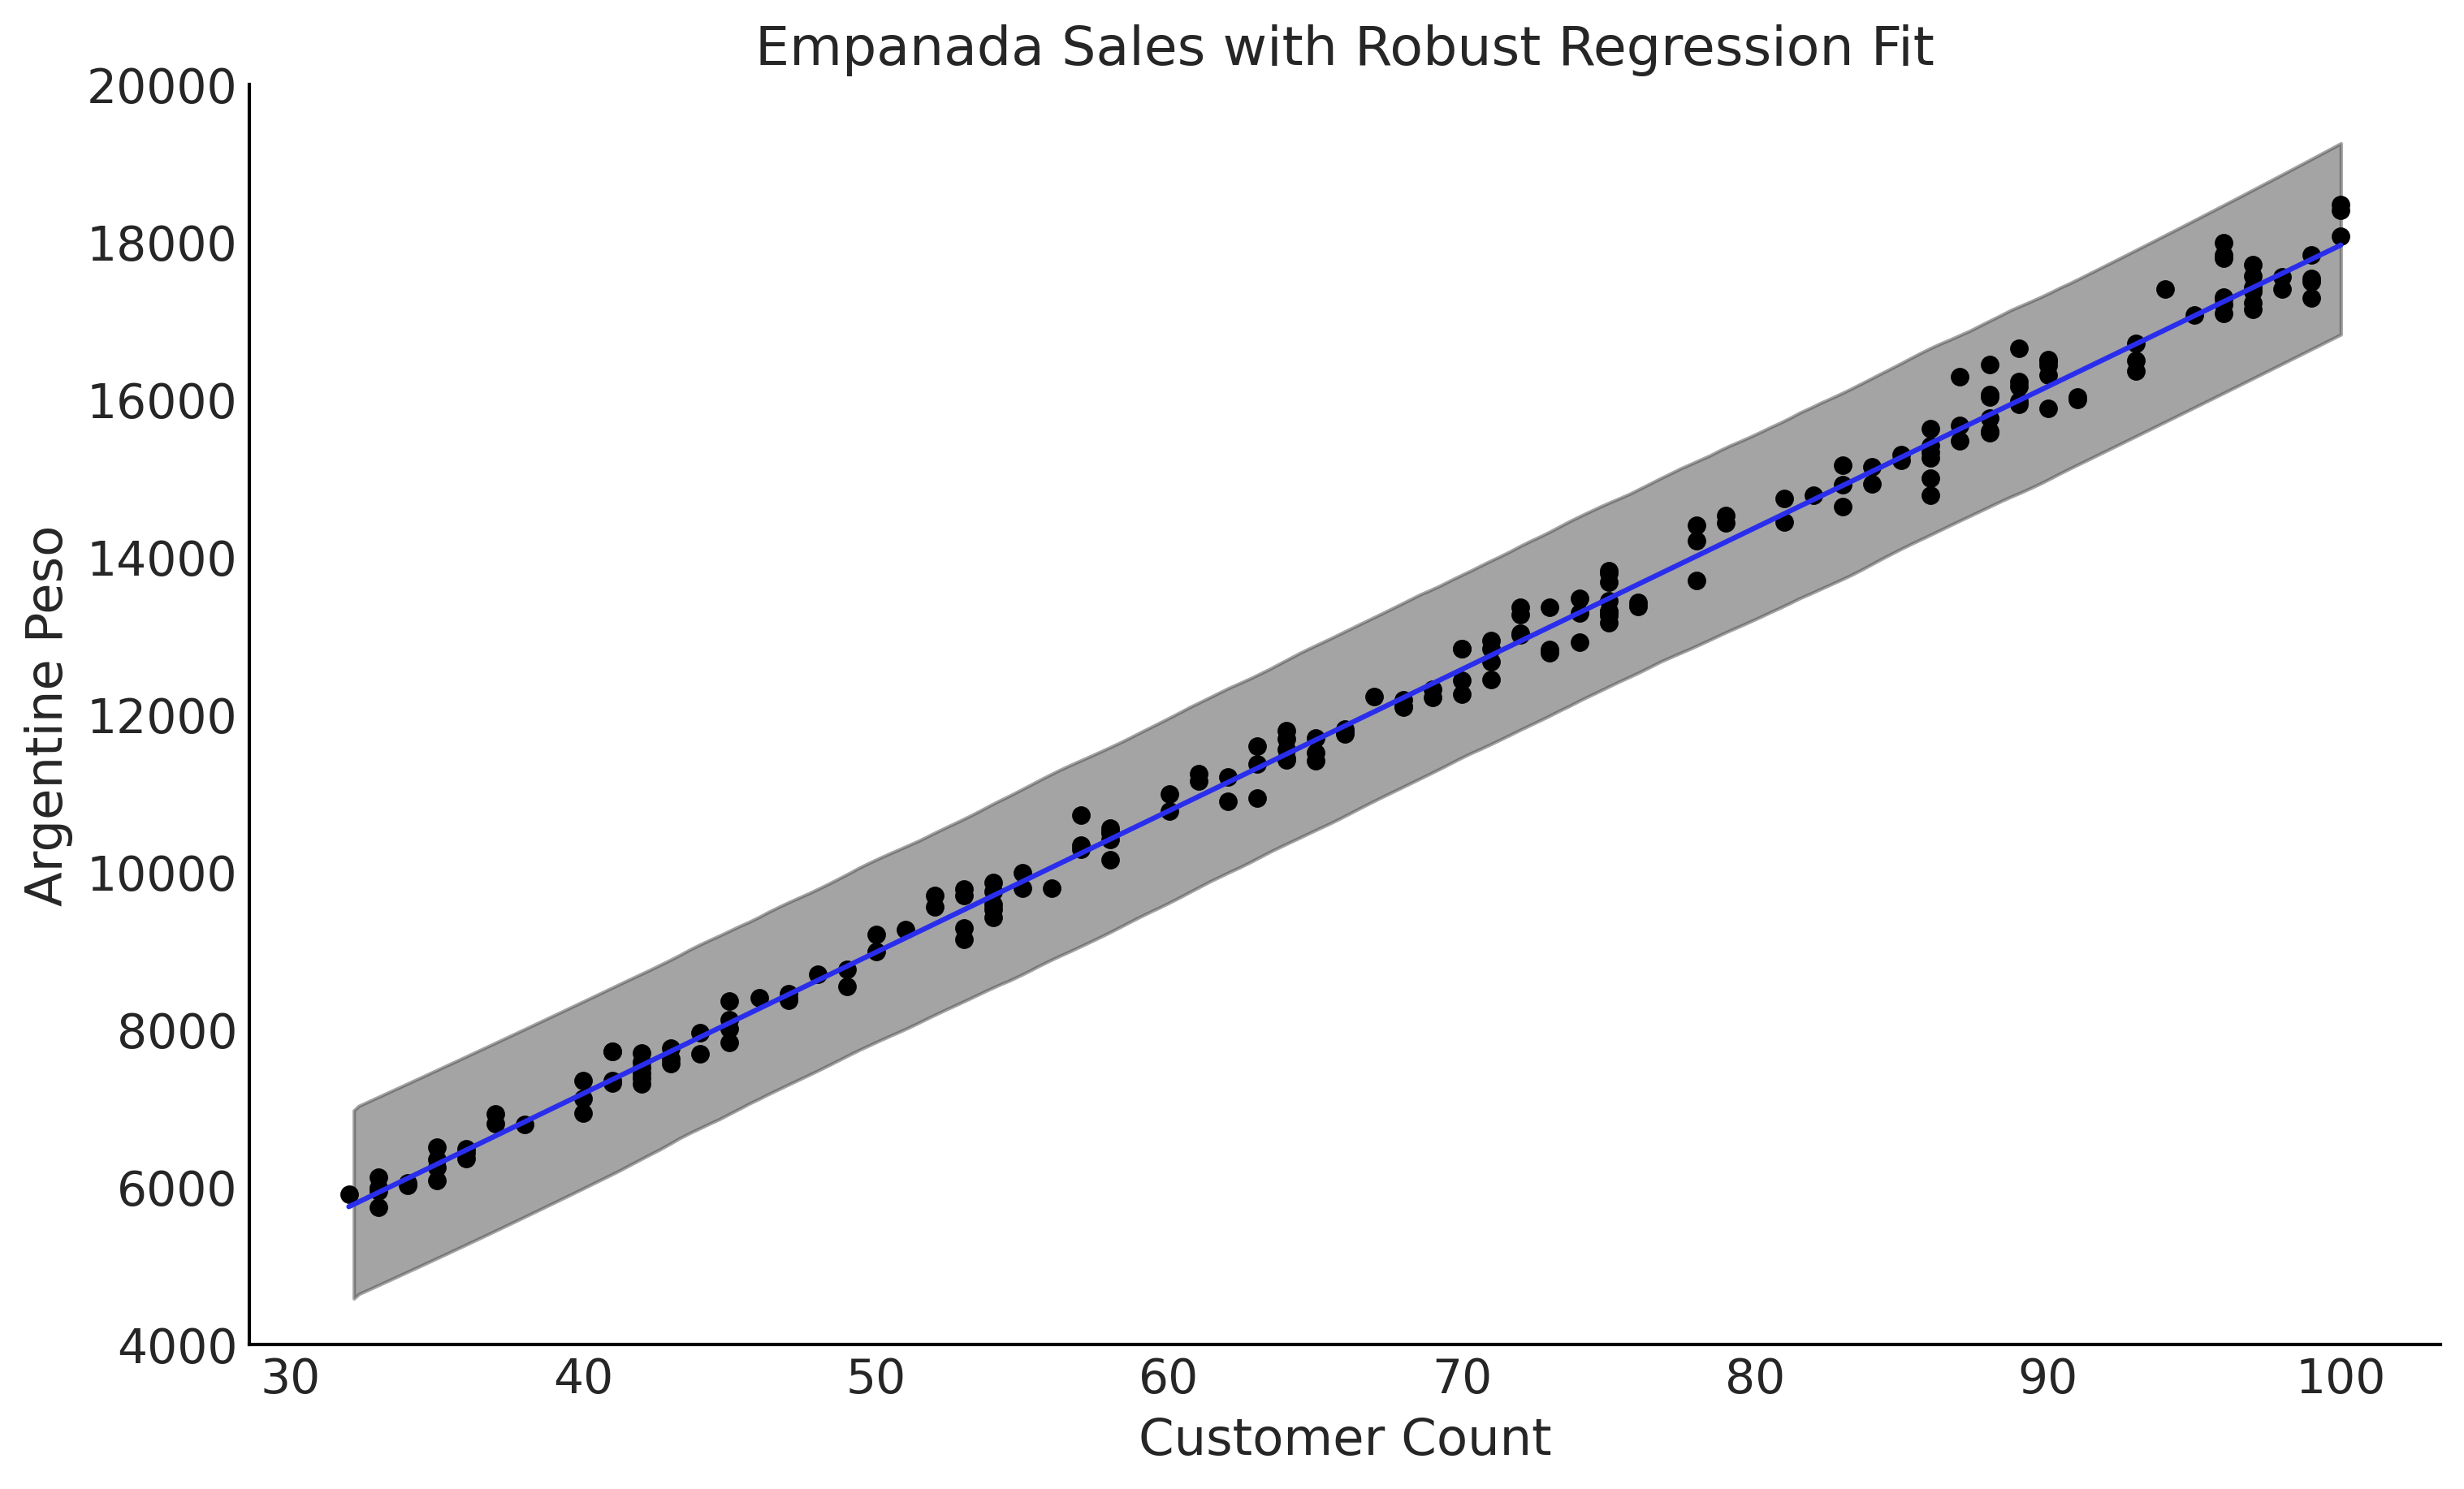

In [133]:
fig, ax = plt.subplots(figsize=(10, 6))
μ_m = inf_data_robust.posterior["μ"].values.reshape(-1, empanadas.shape[0]).mean(axis=0)

ax.plot(empanadas.customers, μ_m, c='C4')
az.plot_hdi(empanadas.customers, inf_data_robust.posterior_predictive["sales"], hdi_prob=.95, ax=ax)

empanadas.plot(x="customers", y="sales", kind="scatter", ax=ax)
ax.set_ylim(4000, 20000);
ax.set_ylabel("Argentine Peso")
ax.set_xlabel("Customer Count")
ax.set_title("Empanada Sales with Robust Regression Fit")

在这个例子中，“异常值”实际上是我们想要建模的问题的一部分，从某种意义上说，它们不是测量误差、数据输入错误等，而是在某些条件下实际发生的观察结果。因此，如果我们想要对“正常”一天的肉馅卷饼平均数量进行建模，那么将它们视为异常值是可以的，但如果我们使用这个平均值来制定下一个节日的计划则会导致灾难。因此可能使用混合模型或多级模型更好地建模效果更好。

## 4.5. Pooling, Multilevel Models, and Mixed Effects

我们的数据集中的预测变量经常包含额外的嵌套结构，这为数据分组提供了一种分层方式。我们也可以将其视为不同的数据生成过程。我们将用一个例子来说明这一点。    
假设你在一家销售沙拉的餐厅公司工作。这家公司在一些地理市场上有着长期的业务，并且由于客户需求，刚刚在新市场开设了一个地点。你需要预测这个新市场的餐厅每天将赚取多少美元，以便进行财务规划。你有两个数据集，一个是3天的沙拉销售数据，另一个是在同一市场上大约一年的披萨和三明治销售数据。

In [134]:
def generate_sales(*, days, mean, std, label):
    np.random.seed(0)
    df = pd.DataFrame(index=range(1, days+1), columns=["customers", "sales"])
    for day in range(1, days+1):
        num_customers = stats.randint(30, 100).rvs()+1
        
        # This is correct as there is an independent draw for each customers orders
        dollar_sales = stats.norm(mean, std).rvs(num_customers).sum()
        
        df.loc[day, "customers"] = num_customers
        df.loc[day, "sales"] = dollar_sales
        
    # Fix the types as not to cause Theano errors
    df = df.astype({'customers': 'int32', 'sales': 'float32'})
    
    # Sorting will make plotting the posterior predictive easier later
    df["Food_Category"] = label
    df = df.sort_values("customers")
    return df

In [136]:
pizza_df = generate_sales(days=365, mean=13, std=5, label="Pizza")
sandwich_df = generate_sales(days=100, mean=6, std=5, label="Sandwich")

salad_days = 3
salad_df = generate_sales(days=salad_days, mean=8 ,std=3, label="Salad")

In [137]:
sales_df = pd.concat([pizza_df, sandwich_df, salad_df]).reset_index(drop=True)
sales_df["Food_Category"] = pd.Categorical(sales_df["Food_Category"])
sales_df

customers       sales Food_Category
0           31  459.895203         Pizza
1           31  401.147736         Pizza
2           31  413.345245         Pizza
3           31  371.909241         Pizza
4           32  433.797089         Pizza
..         ...         ...           ...
463        100  611.736816      Sandwich
464        100  667.152954      Sandwich
465         42  331.625702         Salad
466         66  520.900940         Salad
467         75  628.937622         Salad

[468 rows x 3 columns]

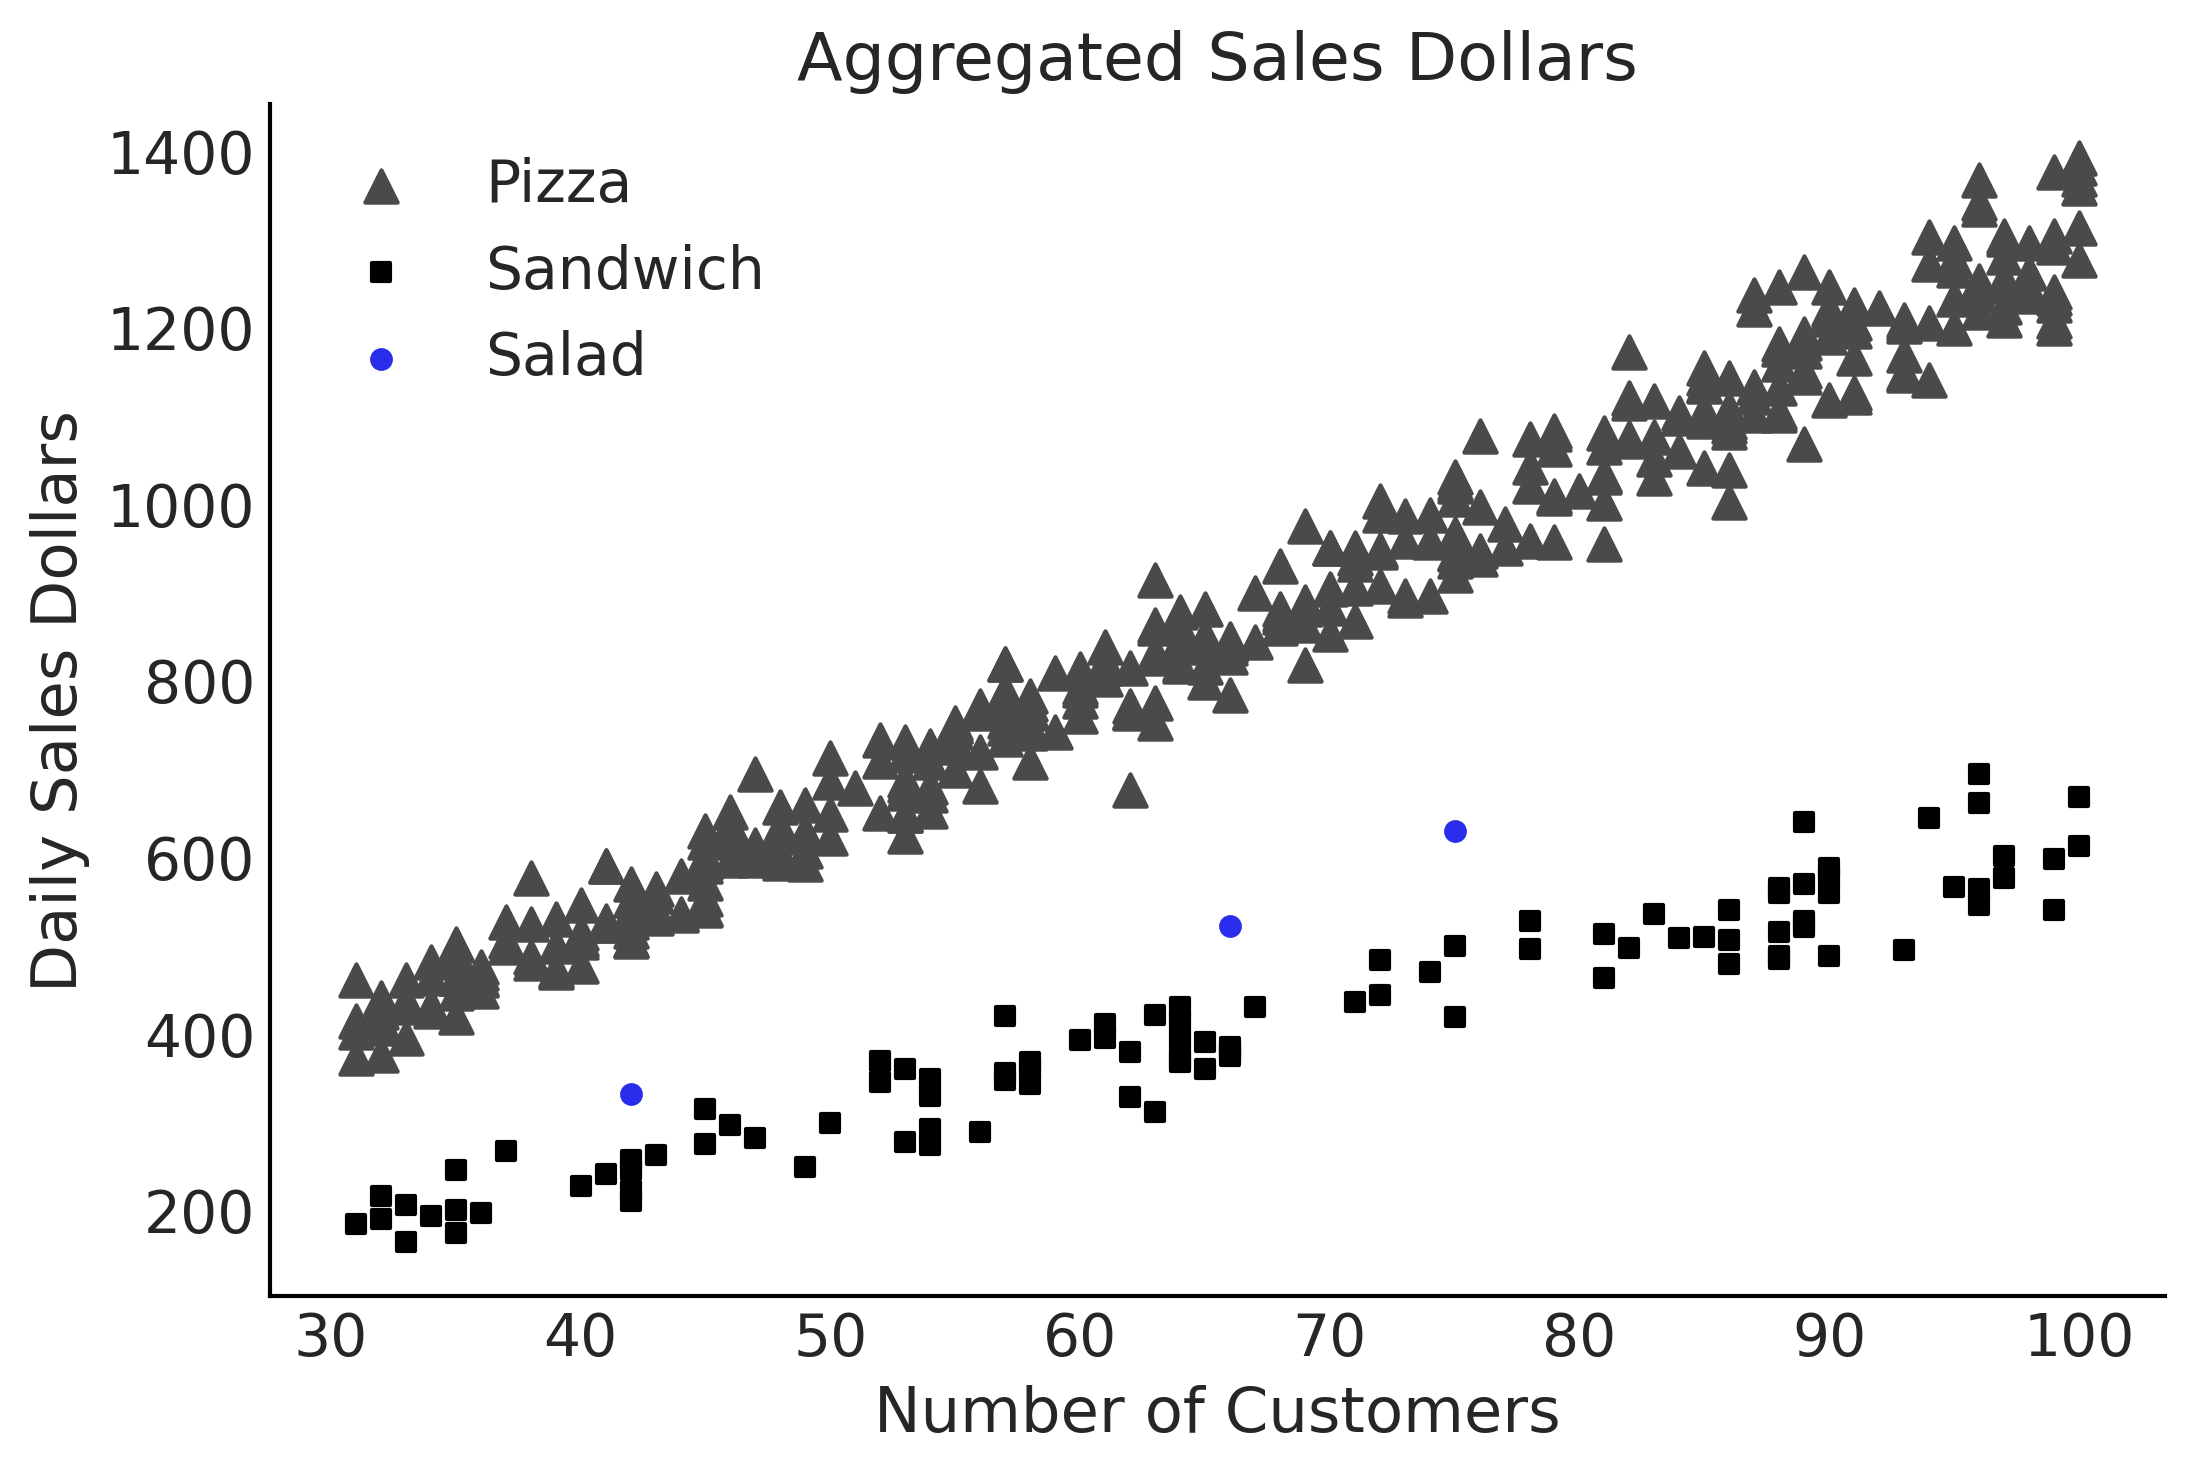

In [138]:
fig, ax = plt.subplots()
pizza_df.plot(x="customers", y="sales", kind="scatter", ax=ax, c="C1", label="Pizza", marker="^", s=60);
sandwich_df.plot(x="customers", y="sales", kind="scatter", ax=ax,  label="Sandwich", marker="s");
salad_df.plot(x="customers", y="sales", kind="scatter", ax=ax, label="Salad", c="C4");

ax.set_xlabel("Number of Customers")
ax.set_ylabel("Daily Sales Dollars")
ax.set_title("Aggregated Sales Dollars")
ax.legend()

从专家知识和数据来看，这三类食品的销售情况存在相似之处。它们都吸引同一类型的顾客，代表相同的快速食品“食品类别”，但它们也不完全相同。在下面的部分中，我们将讨论如何对这种相似但不相似的情况进行建模，但让我们从更简单的情况开始，所有组都彼此无关。

### 4.5.1. Unpooled Parameters

我们可以创建一个回归模型，其中我们将每个组（在这种情况下是食品类别）视为与其他组完全分离。这与为每个类别单独运行回归是一样的，这就是我们称其为非池化回归的原因。运行分离的回归与此的唯一区别是，我们正在编写一个单一的模型，并同时估计所有的系数。
![](unpooled_model.png)

$$\begin{split}
\beta_{mj} \sim& \overbrace{\mathcal{N}(\mu_{\beta m}, \sigma_{\beta m})}^{\text{Group-specific}}\\
\sigma_{j} \sim& \overbrace{\mathcal{HN}(\sigma_{\sigma})}^{\text{Group-specific}}\\
\mu_{j} =& \beta_{1j} X_1 + \dots + \beta_{mj} X_m \\
Y \sim& \mathcal{N}(\mu_{j}, \sigma_{j})
\end{split}$$

我们不包含截距参数，因为如果一家餐厅的顾客为零，那么总销售额也将为零。

In [149]:
customers = sales_df.loc[:, "customers"].values
sales_observed = sales_df.loc[:, "sales"].values
food_category = pd.Categorical(sales_df["Food_Category"])

with pm.Model() as model_sales_unpooled:
    σ = pm.HalfNormal("σ", 20, shape=3)
    β = pm.Normal("β", mu=10, sigma=10, shape=3)
    
    μ = pm.Deterministic("μ", β[food_category.codes] *customers)
    
    sales = pm.Normal("sales", mu=μ, sigma=σ[food_category.codes],
                      observed=sales_observed)
    
    trace_sales_unpooled = pm.sample(target_accept=.9)
    inf_data_sales_unpooled = trace_sales_unpooled.assign_coords({"β_dim_0":food_category.categories,
                "σ_dim_0":food_category.categories})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


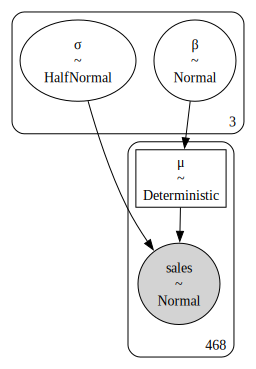

In [150]:
sales_unpooled_diagram = pm.model_to_graphviz(model_sales_unpooled)
sales_unpooled_diagram

在建模后，我们可以绘制参数的 forest plots。可以发现沙拉食品类别不确定性很高。

Text(0.5, 1.0, 'β parameter estimates 94% HDI')

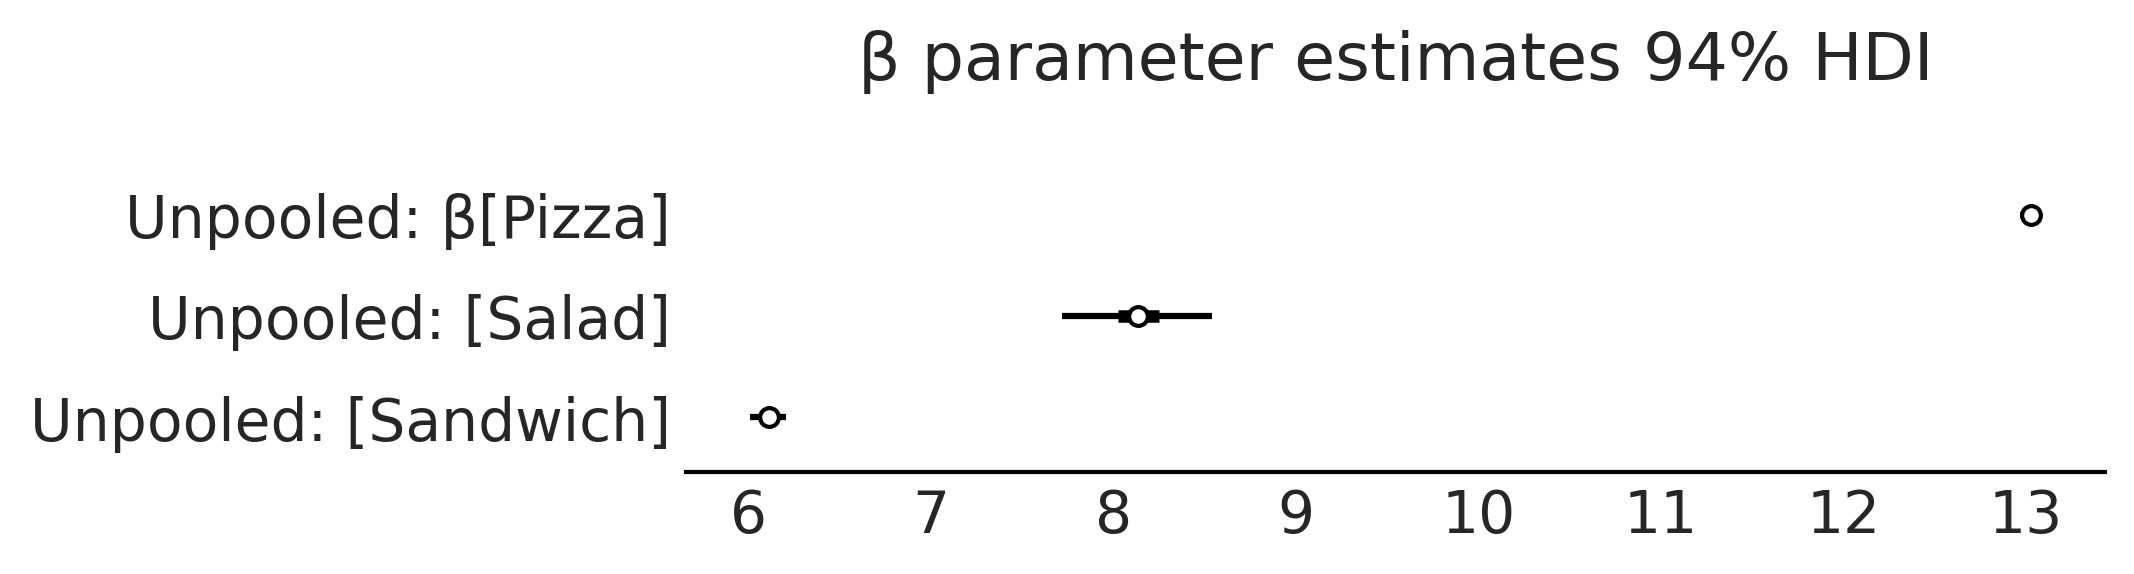

In [151]:
axes = az.plot_forest([inf_data_sales_unpooled],
                      model_names = ["Unpooled",],
                      var_names=["β"], combined=True, figsize=(7, 1.8));
axes[0].set_title("β parameter estimates 94% HDI")

Text(0.5, 1.0, 'σ parameter estimates 94% HDI')

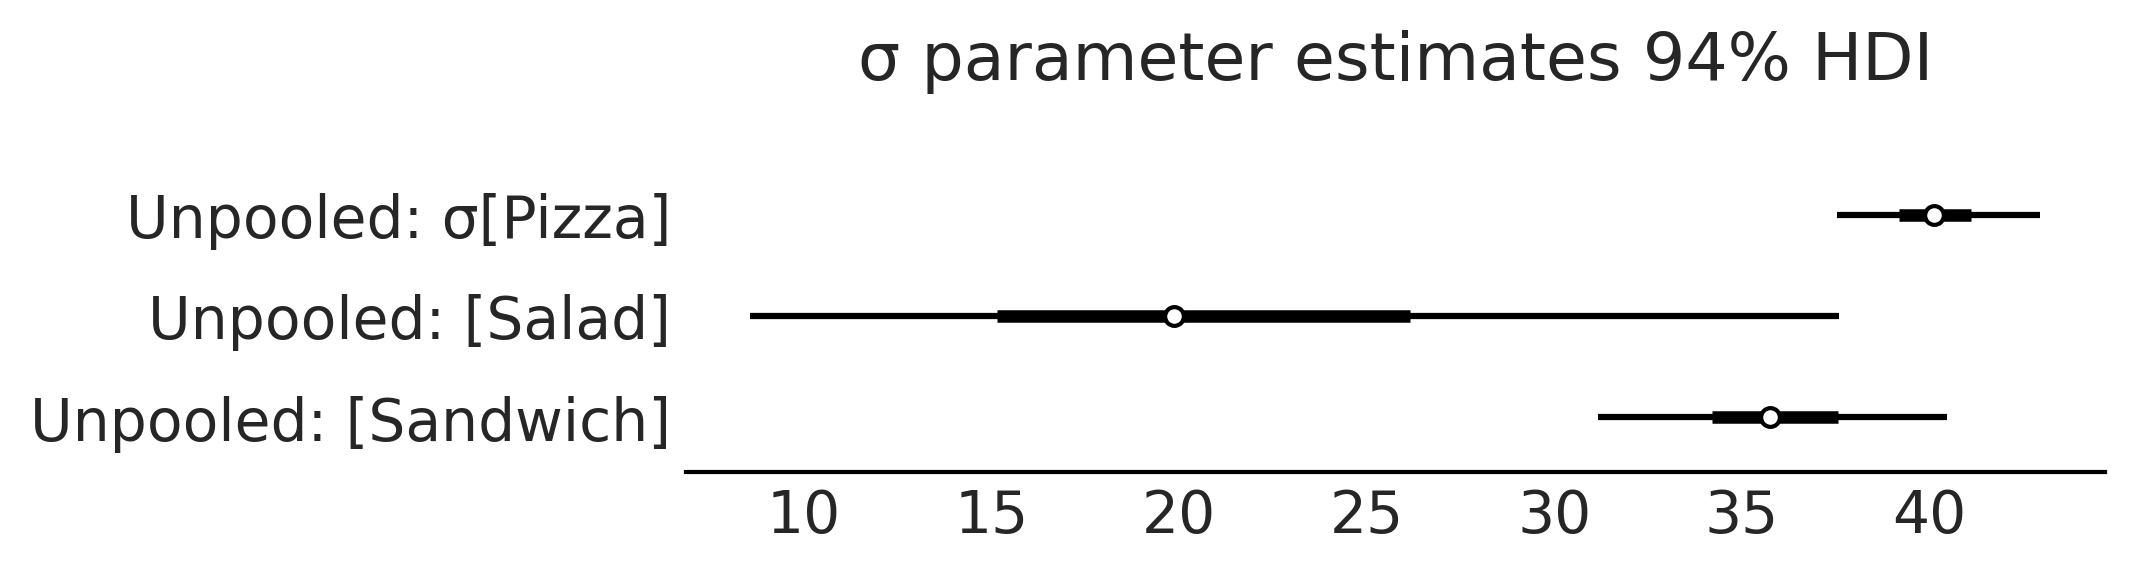

In [153]:
axes = az.plot_forest([inf_data_sales_unpooled,],
                      model_names = ["Unpooled",],
                      var_names=["σ"], combined=True, figsize=(7, 1.8));
axes[0].set_title("σ parameter estimates 94% HDI")

非合并模型与我们使用数据子集创建三个独立模型没有什么不同，就像我们在比较两个（或更多）组部分中所做的那样，其中每个组的参数是单独估计的，因此我们可以考虑非合并模型用于对每组的独立线性回归进行建模的架构语法糖。更重要的是，现在我们可以使用非池化模型及其估计参数作为基线来比较以下部分中的其他模型，特别是了解额外的复杂性是否合理。


### 4.5.2. Pooled Parameters

池参数是忽略组区别的参数。

![](pooled_model.png)

$$\begin{split}
\beta \sim& \overbrace{\mathcal{N}(\mu_{\beta}, \sigma_{\beta})}^{\text{Common}}\\
\sigma \sim& \overbrace{\mathcal{HN}(\sigma_{\sigma})}^{\text{Common}}\\
\mu =& \beta_{1} X_{1} + \dots + \beta_{m} X_{m} \\
Y \sim& \mathcal{N}(\mu, \sigma)
\end{split}$$

In [158]:
with pm.Model() as model_sales_pooled:
    σ = pm.HalfNormal("σ", 20)
    β = pm.Normal("β", mu=10, sigma=10)

    μ = pm.Deterministic("μ", β * customers)
    
    sales = pm.Normal("sales", mu=μ, sigma=σ, observed=sales_observed)
                        
    inf_data_sales_pooled = pm.sample()
    ppc_sales_pooled = pm.sample_posterior_predictive(inf_data_sales_pooled)
    inf_data_sales_pooled.extend(ppc_sales_pooled)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
Sampling: [sales]


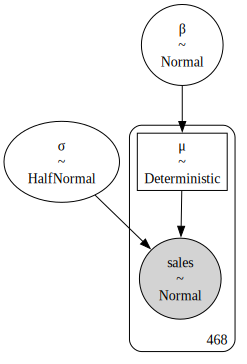

In [155]:
pooled_sales_diagram = pm.model_to_graphviz(model_sales_pooled)
pooled_sales_diagram

Text(0.5, 1.0, 'Comparison of pooled and unpooled models \n 94% HDI')

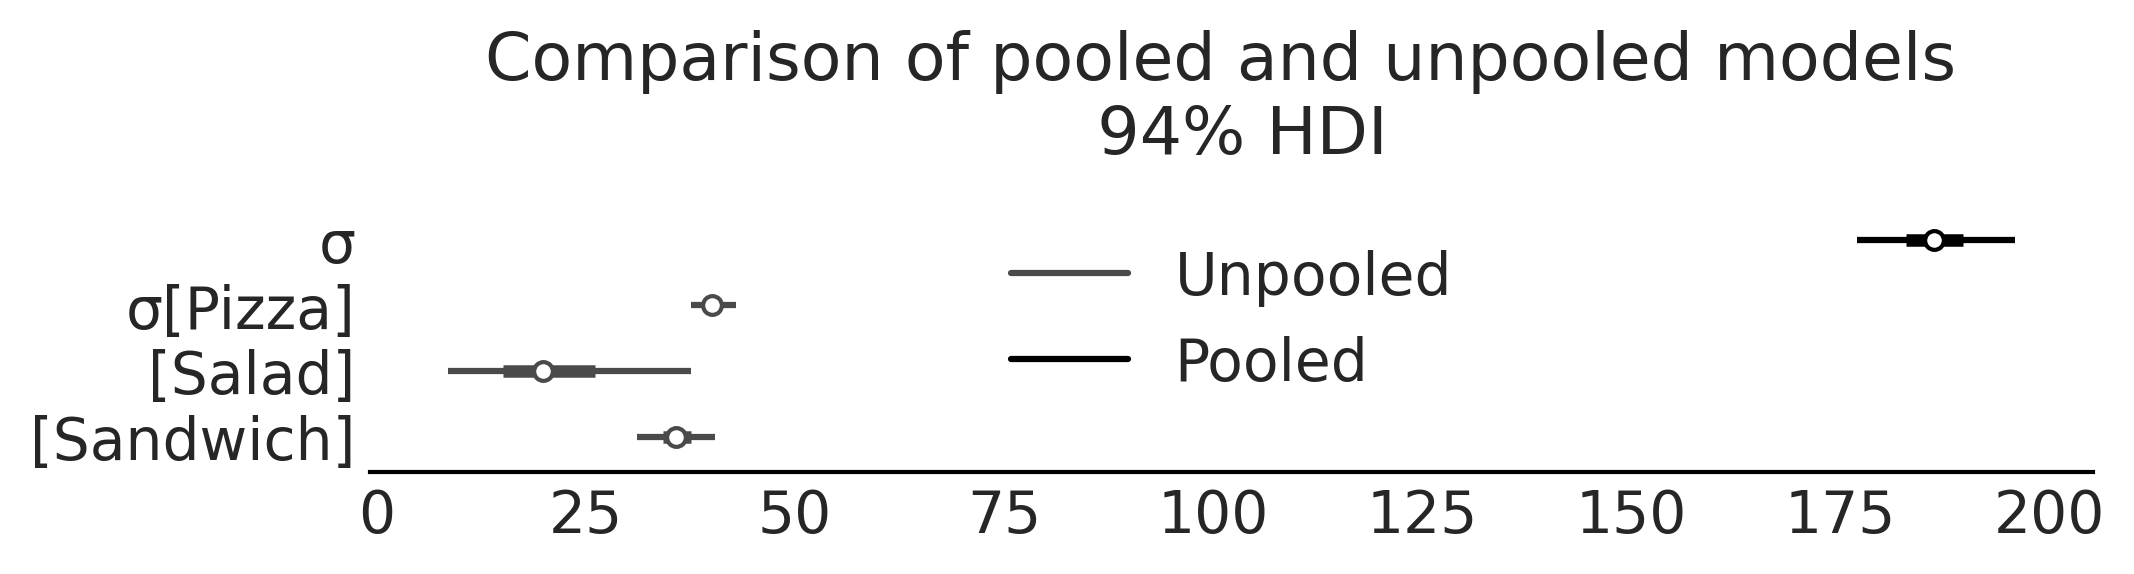

In [156]:
axes = az.plot_forest([inf_data_sales_pooled, inf_data_sales_unpooled],
                      model_names = ["Pooled", "Unpooled"], var_names=["σ"], combined=True, figsize=(7, 1.8));
axes[0].set_title("Comparison of pooled and unpooled models \n 94% HDI")

Text(0.5, 1.0, 'Pooled Regression')

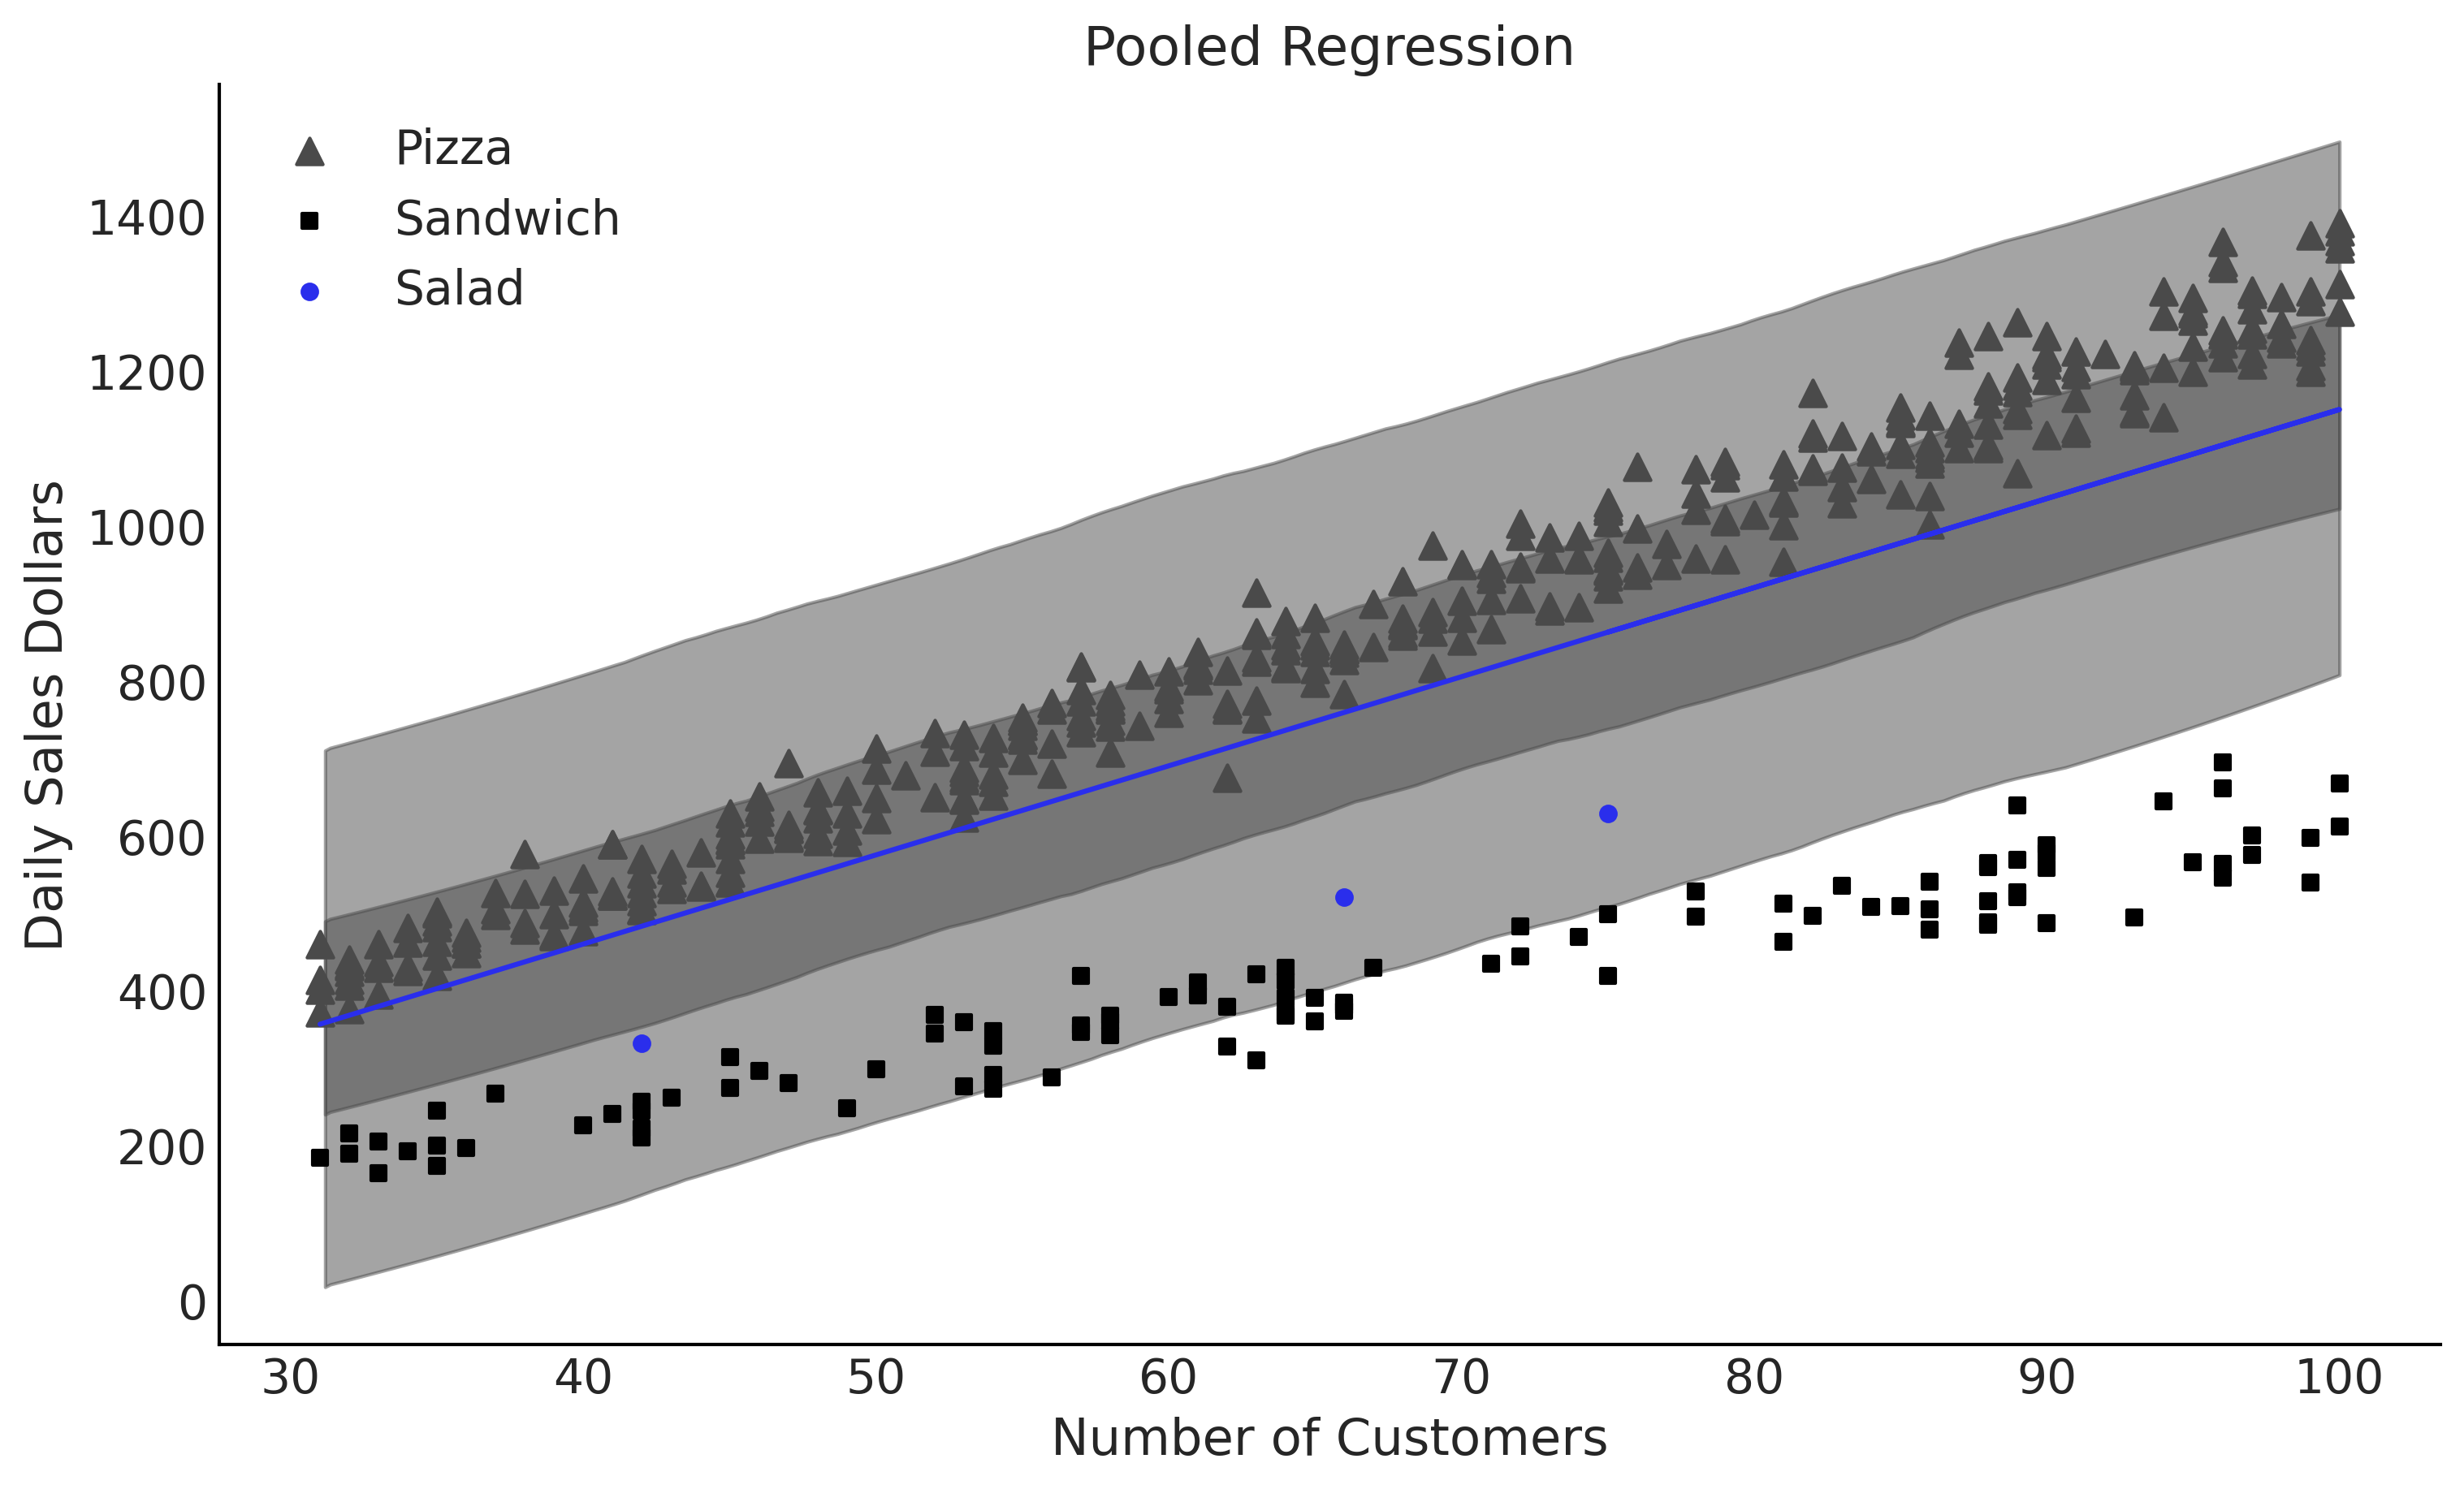

In [161]:
fig, ax = plt.subplots(figsize=(10, 6))
μ_m = inf_data_sales_pooled.posterior["μ"].values.reshape(-1, sales_df.shape[0]).mean(axis=0)
σ_m = inf_data_sales_pooled.posterior["σ"].mean().values

ax.plot(customers, μ_m, c='C4')

az.plot_hdi(customers, inf_data_sales_pooled.posterior_predictive["sales"], hdi_prob=.50, ax=ax)
az.plot_hdi(customers, inf_data_sales_pooled.posterior_predictive["sales"], hdi_prob=.94, ax=ax)


pizza_df.plot(x="customers", y="sales", kind="scatter", ax=ax, c="C1", label="Pizza", marker="^", s=60);
sandwich_df.plot(x="customers", y="sales", kind="scatter", ax=ax,  label="Sandwich", marker="s");
salad_df.plot(x="customers", y="sales", kind="scatter", ax=ax, label="Salad", c="C4");


ax.set_xlabel("Number of Customers")
ax.set_ylabel("Daily Sales Dollars")
ax.set_title("Pooled Regression")

从上面的可视化发现，池化的好处是不确定性降低了，但是预测结果对每组都不太好。

### 4.5.3. Mixing Group and Common Parameters

unpooled 方法对分组差异区别的很好，但是小样本组不确定性很高；pooled 方法样本量增加了，但是无法区分组差异。我们可以将两种方法结合起来，使用混合参数模型。
$$
\begin{split}
\beta_{mj} \sim& \overbrace{\mathcal{N}(\mu_{\beta m}, \sigma_{\beta m})}^{\text{Group-specific}}\\
\sigma \sim& \overbrace{\mathcal{HN}(\sigma_{\sigma})}^{\text{Common}}\\
\mu_{j} =& \beta_{1j} X_{1} + \dots + \beta_{m} X_{m} \\
Y \sim& \mathcal{N}(\mu_{j}, \sigma)
\end{split}
$$

用以上思路重新对数据建模：


In [162]:
with pm.Model() as model_pooled_sigma_sales:
    σ = pm.HalfNormal("σ", 20)
    β = pm.Normal("β", mu=10, sigma=20, shape=3)
    
    μ = pm.Deterministic("μ", β[food_category.codes] * customers)
    
    sales = pm.Normal("sales", mu=μ, sigma=σ, observed=sales_observed)
    
    trace_pooled_sigma_sales = pm.sample()
    ppc_pooled_sigma_sales = pm.sample_posterior_predictive(trace_pooled_sigma_sales)
    trace_pooled_sigma_sales.extend(ppc_pooled_sigma_sales)

    inf_data_pooled_sigma_sales = trace_pooled_sigma_sales.assign_coords({"β_dim_0":food_category.categories})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
Sampling: [sales]


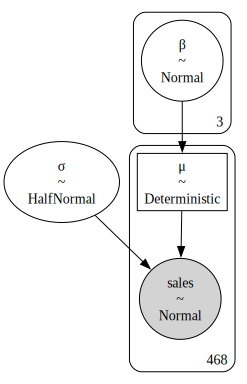

In [163]:
multilevel_sales_diagram = pm.model_to_graphviz(model_pooled_sigma_sales)
multilevel_sales_diagram

In [164]:
az.summary(inf_data_pooled_sigma_sales, var_names=["β", "σ"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
β[Pizza]     13.024  0.030  12.967   13.080      0.000    0.000    5844.0   
β[Salad]      8.127  0.352   7.470    8.786      0.004    0.003    6614.0   
β[Sandwich]   6.113  0.057   6.006    6.216      0.001    0.000    6661.0   
σ            39.260  1.295  36.927   41.748      0.016    0.011    6897.0   

             ess_tail  r_hat  
β[Pizza]       3063.0    1.0  
β[Salad]       3169.0    1.0  
β[Sandwich]    3254.0    1.0  
σ              3266.0    1.0

Text(0.5, 1.0, 'Unpooled Slope Pooled Sigma Regression')

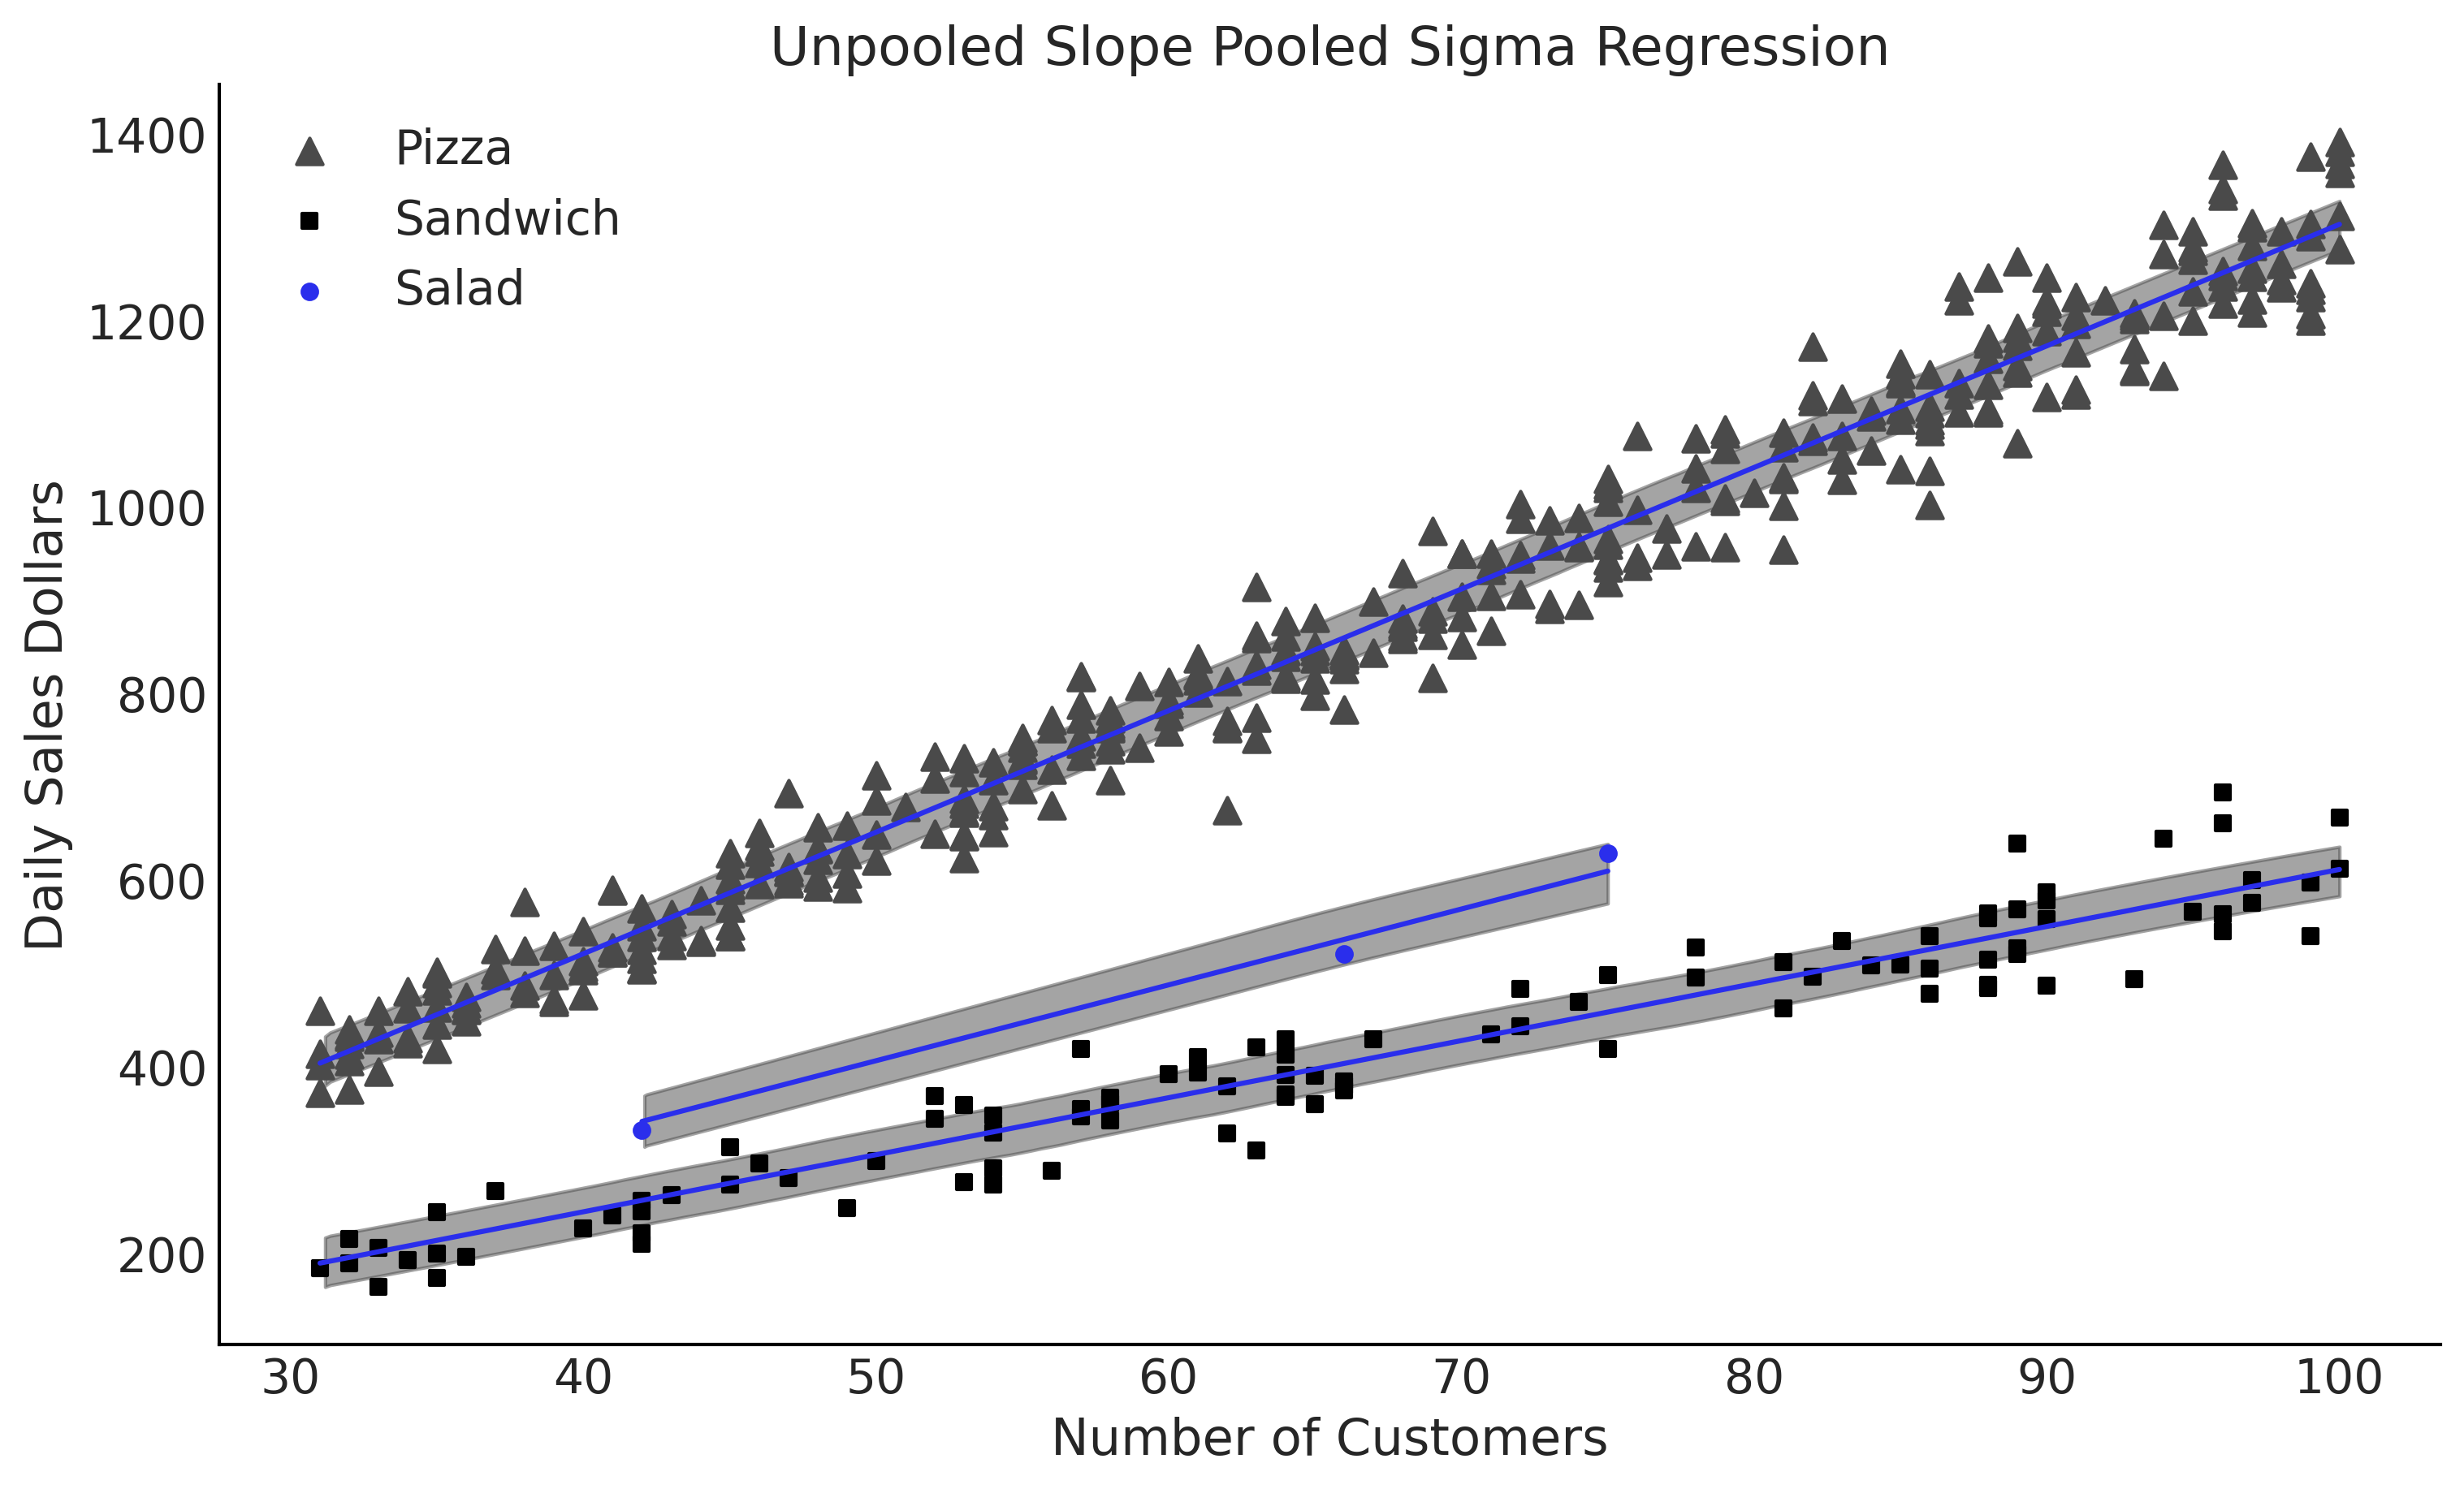

In [165]:
fig, ax = plt.subplots(figsize=(10, 6))
σ_m = inf_data_sales_pooled.posterior["σ"].mean().values

# Salads

for i in range(3):
    category_mask = (food_category.codes==i)
    μ_m_salads = inf_data_pooled_sigma_sales.posterior["μ"][:,:, category_mask].mean(axis=(0,1))
    ax.plot(sales_df.customers[category_mask], μ_m_salads, c='C4')
    az.plot_hdi(sales_df.customers[category_mask], inf_data_pooled_sigma_sales.posterior_predictive["sales"][:,:, (category_mask)], hdi_prob=.50, ax=ax, fill_kwargs={"alpha": .5})
    #az.plot_hdi(sales_df.customers[category_mask], inf_data_pooled_sigma_sales.posterior_predictive["sales"][:,:, (category_mask)], hdi_prob=.94, ax=ax)


pizza_df.plot(x="customers", y="sales", kind="scatter", ax=ax, c="C1", label="Pizza", marker="^", s=60);
sandwich_df.plot(x="customers", y="sales", kind="scatter", ax=ax,  label="Sandwich", marker="s");
salad_df.plot(x="customers", y="sales", kind="scatter", ax=ax, label="Salad", c="C4");


ax.set_xlabel("Number of Customers")
ax.set_ylabel("Daily Sales Dollars")
ax.set_title("Unpooled Slope Pooled Sigma Regression")

Text(0.5, 1.0, 'Comparison of σ parameters 94% HDI')

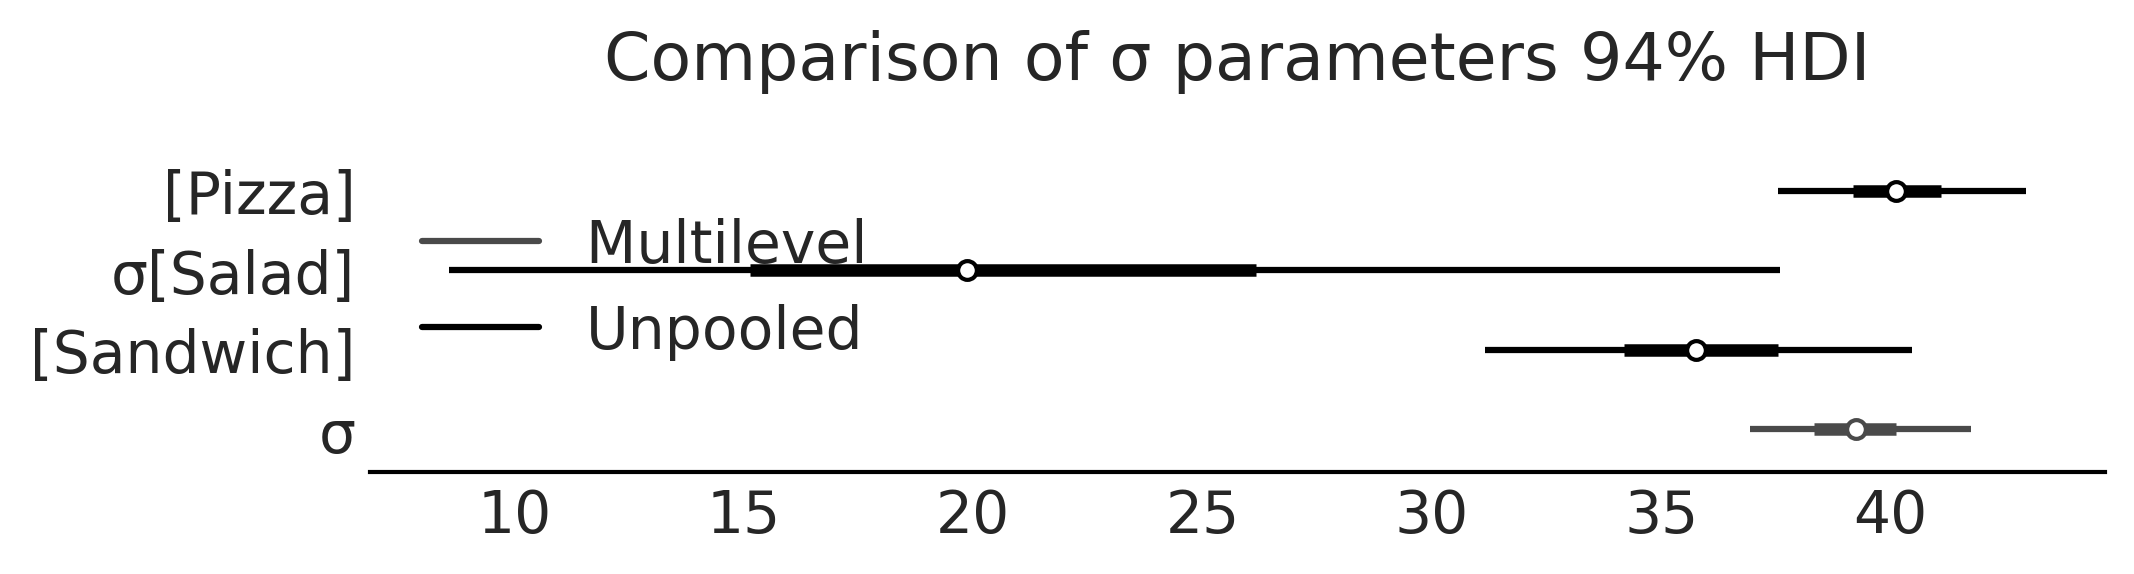

In [166]:
axes = az.plot_forest([inf_data_sales_unpooled,
                       inf_data_pooled_sigma_sales
                      ],
                      model_names = ["Unpooled",
                                     "Multilevel "
                                    ],
                      var_names=["σ"], combined=True, figsize=(7, 1.8));
axes[0].set_title("Comparison of σ parameters 94% HDI")

Text(0.5, 1.0, 'Comparison of β parameters 94% HDI')

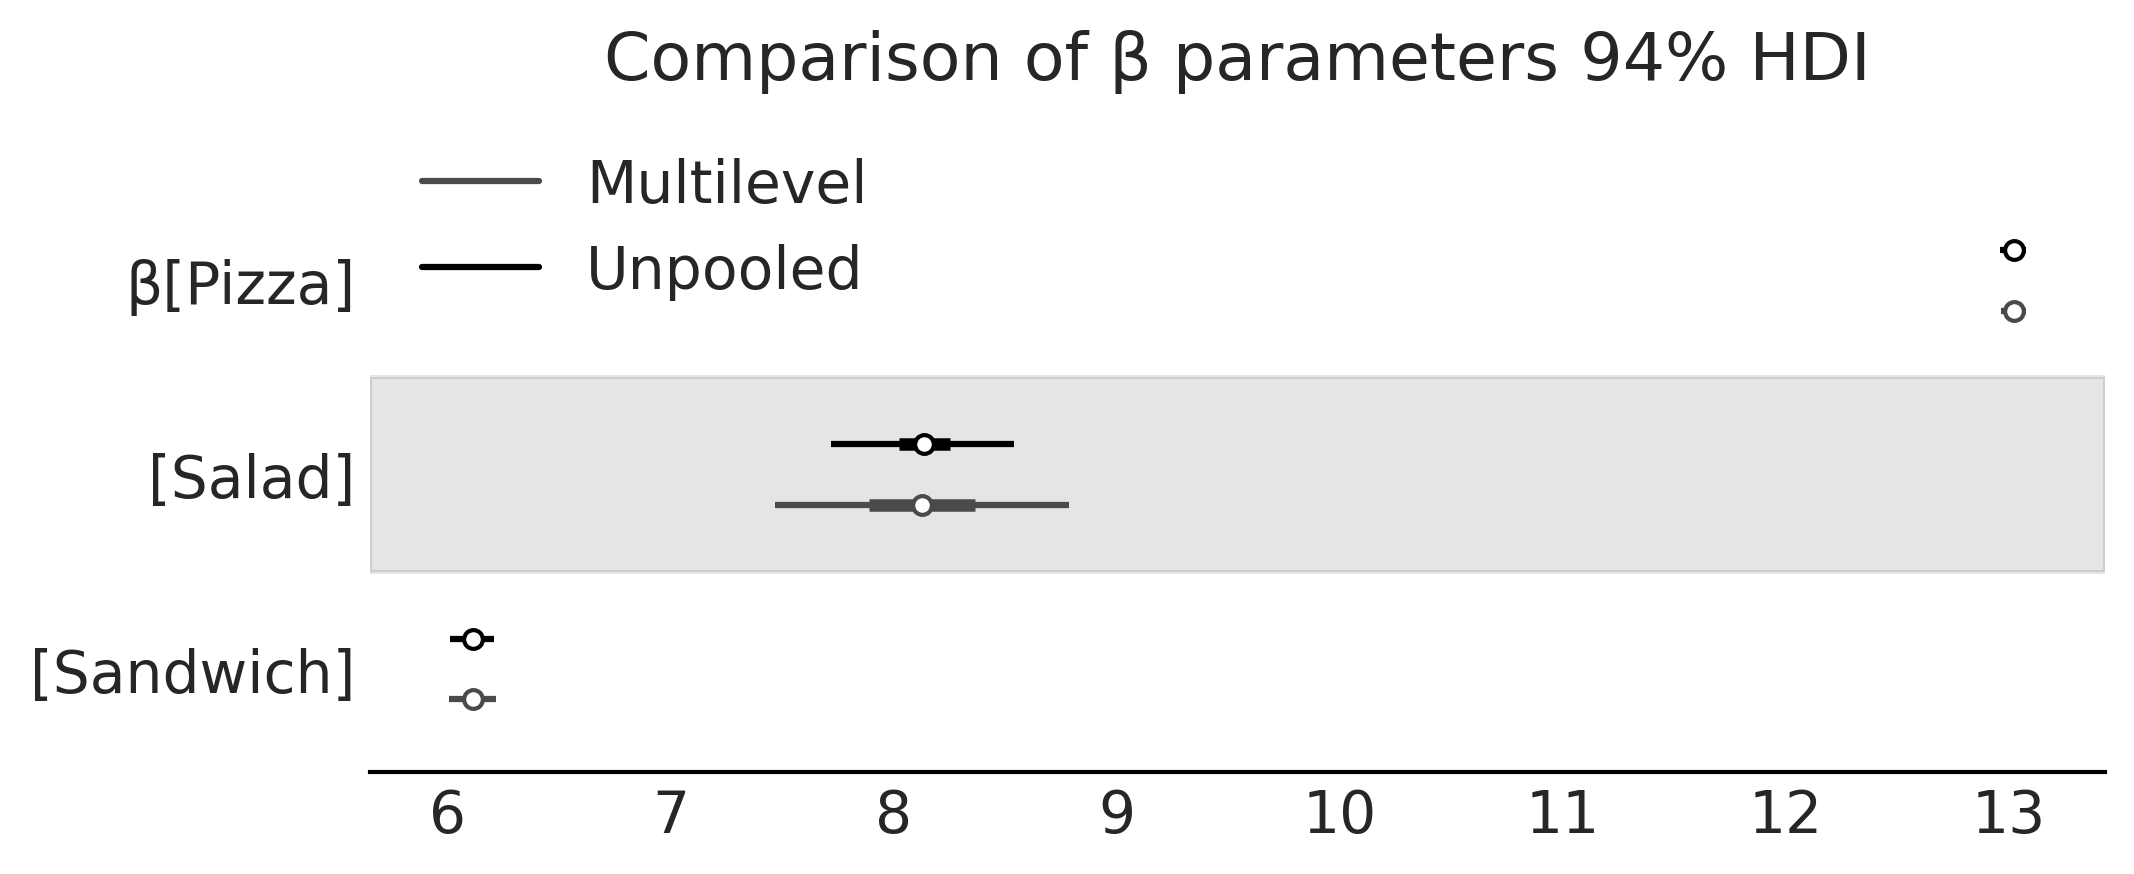

In [167]:
axes = az.plot_forest([inf_data_sales_unpooled,
                       inf_data_pooled_sigma_sales
                      ],
                      model_names = ["Unpooled",
                                     "Multilevel"
                                    ],
                      var_names=["β"], combined=True, figsize=(7, 2.8));
axes[0].set_title("Comparison of β parameters 94% HDI")

## 4.6. 分层模型

在我们迄今为止的数据处理中，我们有两种处理组的选项，池化（pooled）是指没有区分各个组，非池化（unpooled）是指完全区分各个组。然而，回想一下我们初始的餐厅例子，我们认为3种食品类别的参数相似，但并不完全相同。在贝叶斯建模中，我们可以用分层模型来表达这个想法。在分层模型中，参数是部分池化的。部分这个词指的是各个组并不共享一个固定的参数，而是共享一个超先验分布，这个分布描述了先验本身参数的分布。

![](partial_pooled_model.png)

$$\begin{split}
\beta_{mj} \sim& \mathcal{N}(\mu_{\beta m}, \sigma_{\beta m}) \\
\sigma_{h} \sim& \overbrace{\mathcal{HN}(\sigma)}^{\text{Hyperprior}} \\
\sigma_{j} \sim& \overbrace{\mathcal{HN}(\sigma_{h})}^{\substack{\text{Group-specific} \\ \text{pooled}}} \\
\mu_{j} =& \beta_{1j} X_1 + \dots + \beta_{mj} X_m \\
Y \sim& \mathcal{N}(\mu_{j},\sigma_{j})
\end{split}$$

In [168]:
with pm.Model() as model_hierarchical_sales:
    σ_hyperprior = pm.HalfNormal("σ_hyperprior", 20)
    σ = pm.HalfNormal("σ", σ_hyperprior, shape=3)
    
    β = pm.Normal("β", mu=10, sigma=20, shape=3)
    μ = pm.Deterministic("μ", β[food_category.codes] * customers)
    
    sales = pm.Normal("sales", mu=μ, sigma=σ[food_category.codes],
                      observed=sales_observed)
    
    trace_hierarchical_sales = pm.sample(target_accept=.9)
    
    inf_data_hierarchical_sales = trace_hierarchical_sales.assign_coords(
        {"β_dim_0":food_category.categories,
                "σ_dim_0":food_category.categories}
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_hyperprior, σ, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


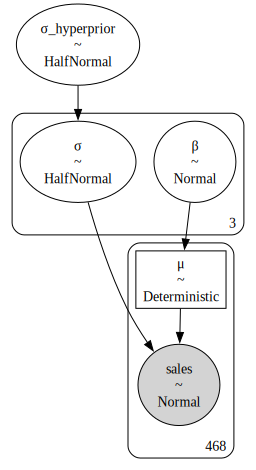

In [169]:
hierarchial_sales_diagram = pm.model_to_graphviz(model_hierarchical_sales)
hierarchial_sales_diagram

Text(0.5, 1.0, 'Hierarchical β estimates 94% HDI')

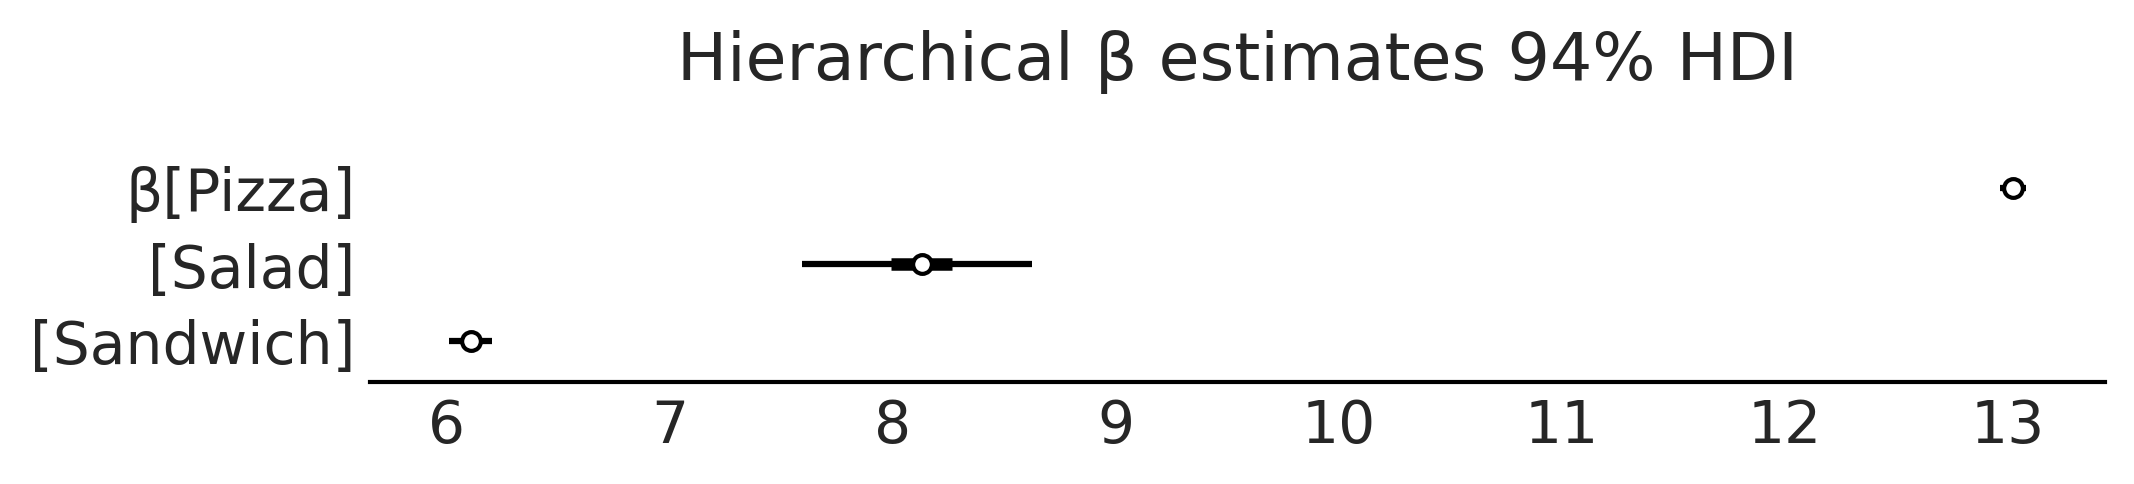

In [170]:
axes = az.plot_forest(inf_data_hierarchical_sales, var_names=["β"], combined=True,  figsize=(7, 1.5))
axes[0].set_title("Hierarchical β estimates 94% HDI")

Text(0.5, 1.0, 'Hierarchical σ estimates 94% HDI')

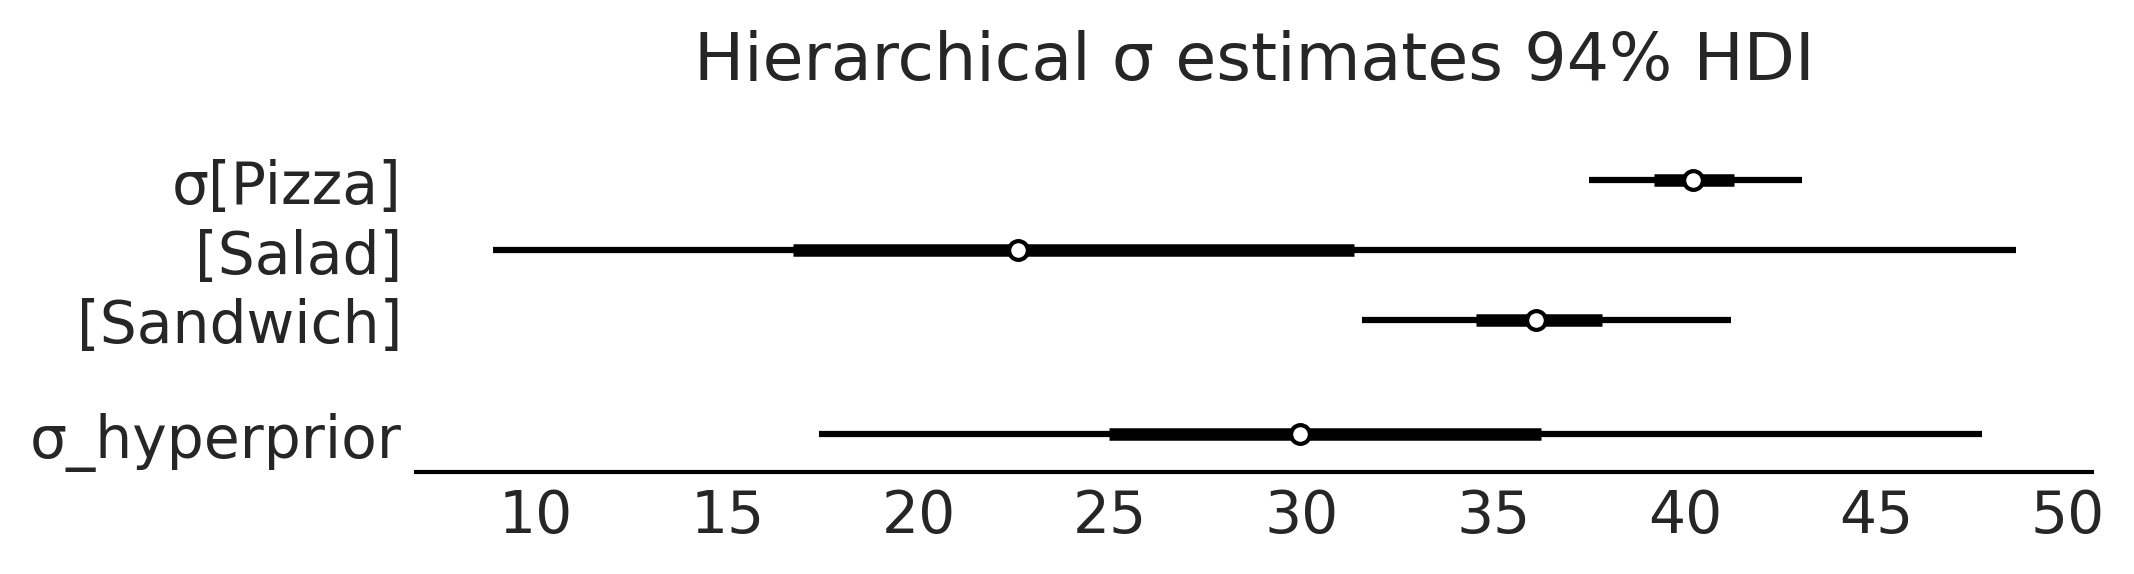

In [171]:
axes = az.plot_forest(inf_data_hierarchical_sales, var_names=["σ", "σ_hyperprior"], combined=True,  figsize=(7, 1.8))
axes[0].set_title("Hierarchical σ estimates 94% HDI")

Text(0.5, 1.0, 'Comparison of σ parameters from unpooled \n and hierarchical models \n 94% HDI')

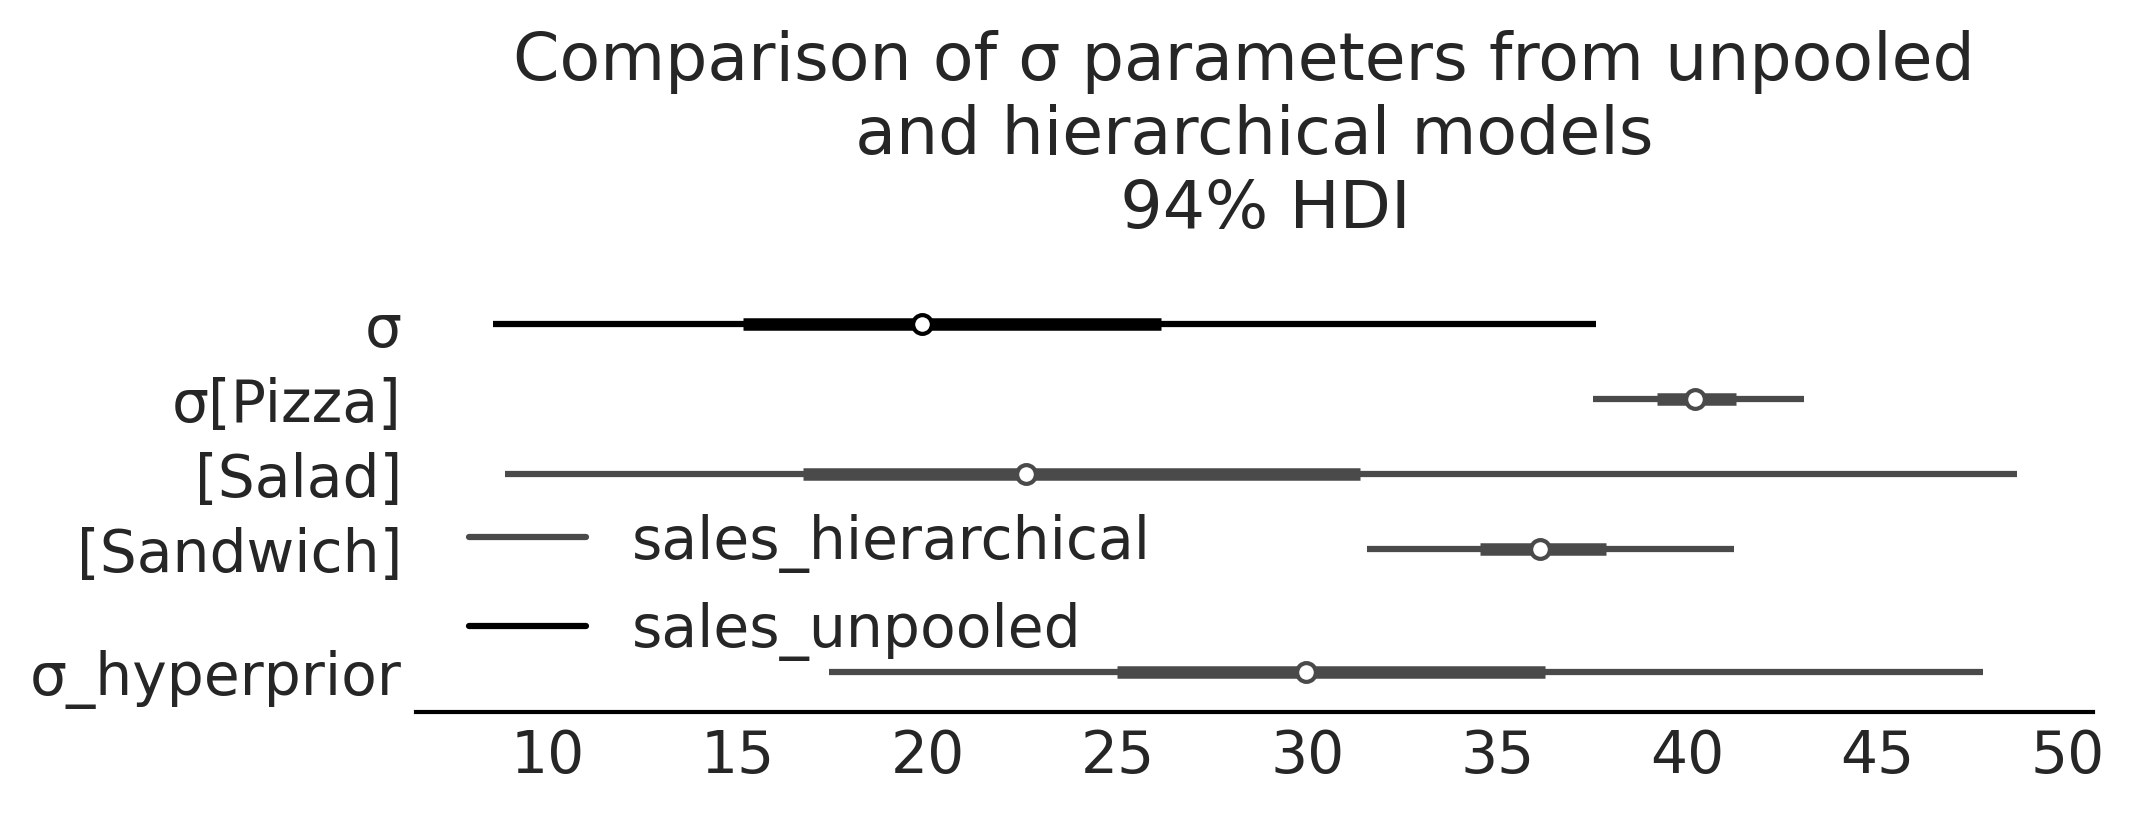

In [172]:
axes = az.plot_forest([inf_data_sales_unpooled.posterior["σ"].isel(σ_dim_0=1),
                       inf_data_hierarchical_sales
                      ],
                      model_names = ["sales_unpooled",
                                     "sales_hierarchical"
                                    ], combined=True, figsize=(7, 2.6),
                     var_names=["σ", "σ_hyperprior"]
                     );
axes[0].set_title("Comparison of σ parameters from unpooled \n and hierarchical models \n 94% HDI")

在非池化估计中，沙拉的sigma估计的平均值是21.6，而在分层估计中，同一参数估计的平均值现在是25.7，被披萨和三明治类别的平均值"拉"高了。此外，分层类别中披萨和三明治类别的估计值，虽然稍微向平均值回归，但基本上与非池化估计值保持一致。注意每个sigma的估计值是如何明显不同的。考虑到我们观察到的数据和模型并没有在组之间共享信息，这与我们的预期一致。

In [173]:
az.summary(inf_data_sales_unpooled.posterior["σ"], kind="stats").round(1)

mean   sd  hdi_3%  hdi_97%
σ[Pizza]     40.2  1.4    37.5     43.0
σ[Salad]     21.6  8.7     8.6     37.6
σ[Sandwich]  35.9  2.5    31.2     40.5

In [174]:
az.summary(inf_data_hierarchical_sales, var_names=["σ", "σ_hyperprior"], kind="stats").round(1)

mean    sd  hdi_3%  hdi_97%
σ[Pizza]      40.3   1.5    37.5     43.1
σ[Salad]      25.7  12.7     8.9     48.7
σ[Sandwich]   36.3   2.6    31.6     41.2
σ_hyperprior  31.3   8.7    17.4     47.8

层次估计不仅仅限于两个层次。例如，餐厅销售模型可以扩展为三级分层模型，其中顶层代表公司级别，下一级代表地理市场（纽约、芝加哥、洛杉矶），最底层代表个人地点。通过这样做，我们可以得到一个描述整个公司表现如何的超先验，表明一个地区表现如何的超先验，以及表示每个商店表现如何的先验。这样可以轻松比较平均值和变化，并基于单个模型以多种不同方式扩展应用程序。

### 4.6.1. 后验分布的几何形状很重要 Posterior Geometry Matters

到目前为止，我们主要关注的是模型背后的结构和数学原理，并假设我们的采样器能够为我们提供后验的“准确”估计。对于相对简单的模型，这基本上是正确的，最新版本的通用推理引擎大多数情况下都能“正常工作”，但重要的一点是，它们并不总是能够正常工作。某些后验的几何形状对采样器来说是具有挑战性的，一个常见的例子是Neal的漏斗，如图所示。正如漏斗这个名字所暗示的，一端的形状非常宽，然后缩小到一个小颈部。回想一下DIY采样器，不要在家尝试这一节，采样器的功能是从一组参数值步进到另一组，一个关键的设置是在探索后验表面时应该走多大的步子。在复杂的几何形状中，比如Neal的漏斗，一个在某个区域工作得很好的步长，在另一个区域可能会失败得很惨。

![](Neals_Funnel.png)

在分层模型中，几何形状主要由超先验与其他参数的相关性定义，这可能导致难以采样的漏斗几何形状。不幸的是，这不仅是一个理论问题，而且是一个实际问题，它可以相对快速地悄悄出现在毫无戒心的贝叶斯建模者面前。幸运的是，有一个相对简单的模型调整，被称为非中心参数化，可以帮助缓解这个问题。  
    
继续我们的沙拉例子，假设我们开了6家沙拉餐厅，和之前一样，我们对预测销售额作为客户数量的函数感兴趣。这个合成数据集是用Python生成的。由于餐厅销售的产品完全相同，分层模型适合在各组之间共享信息。
$$\begin{split}
\beta_{\mu h} \sim& \mathcal{N} \\
\beta_{\sigma h} \sim& \mathcal{HN} \\
\beta_m \sim& \overbrace{\mathcal{N}(\beta_{\mu h},\beta_{\sigma h})}^{\text{Centered}}  \\
\sigma_{h} \sim& \mathcal{HN} \\
\sigma_{m} \sim& \mathcal{HN}(\sigma_{h}) \\
Y \sim& \mathcal{N}(\beta_{m} * X_m,\sigma_{m})
\end{split}$$

运行我们的模型后，首先出现问题的迹象是发散，我们在`divergences`一节中详细介绍了这个问题。样本空间的绘图是一个诊断工具。注意，当超先验$\beta_{\sigma h}$接近零时，$\beta_m$参数的后验估计的宽度趋于缩小。特别注意，附近没有样本。换句话说，当$\beta_{\sigma h}$的值接近零时，用于采样参数$\beta_m$的区域会崩溃，采样器无法有效地描述这个后验的空间。

![](Neals_Funnel_Salad_Centered.png)    

为了缓解这个问题，可以将中心参数化转换为非中心参数化。关键的区别是，它不是直接估计斜率$\beta_m$的参数，而是将其建模为所有组共享的公共项和每个组的项，这个项捕获了从公共项的偏差。这以一种方式修改了后验几何形状，使得采样器更容易探索$\beta_{\sigma h}$的所有可能值。

$$
\begin{split}
\beta_{\mu h} \sim& \mathcal{N} \\
\beta_{\sigma h} \sim& \mathcal{HN} \\
\beta_\text{m\_offset} \sim& \mathcal{N}(0,1) \\
\beta_m =& \overbrace{\beta_{\mu h} + \beta_\text{m\_offset}*\beta_{\sigma h}}^{\text{Non-centered}}  \\
\sigma_{h} \sim& \mathcal{HN} \\
\sigma_{m} \sim& \mathcal{HN}(\sigma_{h}) \\
Y \sim& \mathcal{N}(\beta_{m} * X_m,\sigma_{m})
\end{split}
$$

![](Neals_Funnel_Salad_NonCentered.png)

采样的改进对估计分布产生了实质性的影响。虽然再次被提醒这个事实可能会让人感到不安，但采样器只是估计后验分布，虽然在许多情况下它们做得很好，但这并不是保证！一定要注意诊断结果，如果出现警告，就要更深入地调查。    
    
值得注意的是，对于中心化或非中心化参数化，没有一种适合所有情况的解决方案。这是个体在组级别的可能性信息、组级别先验的信息性以及参数化之间复杂的相互作用（通常，你对特定组有的数据越多，可能性函数就越有信息）。一个通用的启发式规则是，如果没有很多观察值，那么优先选择非中心化参数化。然而，在实践中，你应该尝试几种不同的中心化和非中心化参数化的组合，以及不同的先验规格。你甚至可能发现在一个模型中需要同时使用中心化和非中心化参数化。如果你怀疑模型参数化正在导致你的采样问题，我们建议你阅读Michael Betancourt的案例研究Hierarchical Modeling。

![](Salad_Sales_Hierarchical_Comparison.png)

### 4.6.2. Predictions at Multiple Levels

分层模型的一个微妙特性是它们能够在多个层次上进行估计。虽然这看起来很明显，但它非常有用，因为它让我们可以使用一个模型来回答比单层模型更多的问题。在第三章中，我们可以构建一个模型来估计单个物种的质量，或者构建一个模型来估计任何企鹅的质量，而不考虑物种。使用分层模型，我们可以同时用一个模型估计所有企鹅的质量，以及每个企鹅物种的质量。使用我们的沙拉销售模型，我们既可以对个别位置进行估计，也可以对整个人口进行估计。    
    
另一个使用具有超先验的分层模型进行预测的特性是，我们可以对从未见过的组进行预测。在这种情况下，假设我们在一个新的地点开设了另一家沙拉餐厅，我们可以通过首先从超先验中抽样以获取新地点的 $\beta_{i+1}$ 和 $\sigma_{i+1}$，然后从后验预测分布中抽样以获取沙拉销售预测，从而对沙拉销售可能的情况进行一些预测。    
    
除了分层建模的数学优势外，从计算角度来看，我们只需要构建和拟合一个模型，这也是一个优点。这加快了建模过程和后续的模型维护过程，如果模型在一段时间内被多次重用的话。

### 4.6.3. Priors for Multilevel Models

对于多层模型，先验选择更为重要，因为先验如何与可能性的信息性相互作用，如上文“后验几何形状的重要性”一节所示。此外，不仅先验分布的形状很重要，我们还有如何参数化它们的额外选择。这并不限制我们使用高斯先验，因为它适用于 location-scale 分布家族中的所有分布。    
    
在多层模型中，先验分布不仅描述了组内变异，还描述了组间变异。从某种意义上说，选择超先验就是定义“变异的变异”，这可能使表达和推理关于先验信息变得困难。此外，由于部分池化的效果是超先验的信息性、你拥有的组数以及每个组中的观察数的组合。因此，如果你在使用相同的模型对类似的数据集进行推断，但组数较少，那么相同的超先验可能就不起作用了。    
    
因此，除了经验性的经验（例如，发表在文章中的一般建议）或一般性的建议，我们还可以进行敏感性研究，以更好地指导我们的先验选择。例如，Lemoine 展示了当使用模型结构对生态数据建模时

$$\begin{split}
    \alpha_i \sim& \mathcal{N}(\mu_{\alpha},\sigma^2_{\alpha}) \\
    \mu_{i} =& \alpha_i + \beta Day_i \\
    Y \sim& \mathcal{N}(\mu_{j},\sigma^2)
\end{split}$$

其中，截距是未池化的，Cauchy先验在少量数据点提供正则化，并且在模型拟合额外数据时不会模糊后验。这是通过对先验参数化和不同数量的数据进行先验敏感性分析来完成的。在你自己的多层模型中，一定要注意先验选择影响推断的多种方式，并使用你的领域专业知识或者如先验预测分布这样的工具来做出明智的选择。